# Test Attack

In [1]:
import os

In [34]:
g_path = "/remote-home/songtianwei/research/unlearn_multimodal/output/text_guide_target_gen_nus-wide_ViT-B-16/checkpoint_epoch_195.pth"

In [3]:
import argparse
import torch
import clip
import os
from torchvision.datasets import  MNIST, CIFAR10, CIFAR100, ImageNet
import numpy as np
from tqdm import tqdm
import ruamel.yaml as yaml
import clip
from pathlib import Path

from torchvision import transforms
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC
from models.model_gan_generator import NetG
import utils

import torch.nn.functional as F

In [5]:
device = "cuda:1"

In [35]:
generator = NetG()
checkpoint = torch.load(g_path, map_location=device)
generator.load_state_dict(checkpoint['model'])
generator = generator.to(device)

In [36]:
def _convert_image_to_rgb(image):
    return image.convert("RGB")

In [37]:

# [224,224]
clip_transform = transforms.Compose([
    Resize((224,224),interpolation=BICUBIC),
    CenterCrop(224),
    _convert_image_to_rgb,
    ToTensor(),
])
clip_normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

prompt_templates = [
    'a photo of a {}.',
    'a blurry photo of a {}.',
    'a black and white photo of a {}.',
    'a low contrast photo of a {}.',
    'a high contrast photo of a {}.',
    'a bad photo of a {}.',
    'a good photo of a {}.',
    'a photo of a small {}.',
    'a photo of a big {}.',
    'a photo of the {}.',
    'a blurry photo of the {}.',
    'a black and white photo of the {}.',
    'a low contrast photo of the {}.',
    'a high contrast photo of the {}.',
    'a bad photo of the {}.',
    'a good photo of the {}.',
    'a photo of the small {}.',
    'a photo of the big {}.',
]


def zeroshot_classifier(clip_model, device, classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).to(device) #tokenize
            class_embeddings = clip_model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
    return zeroshot_weights


@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


In [38]:
dataset = CIFAR10(root=os.path.expanduser("~/.cache"), download=True, train=False, transform=clip_transform)

Files already downloaded and verified


In [39]:
data1 = dataset[1]

In [40]:
data1

(tensor([[[0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          [0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          [0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          ...,
          [0.3451, 0.3412, 0.3373,  ..., 0.7294, 0.7333, 0.7333],
          [0.3451, 0.3412, 0.3373,  ..., 0.7294, 0.7333, 0.7333],
          [0.3451, 0.3412, 0.3373,  ..., 0.7294, 0.7333, 0.7333]],
 
         [[0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          [0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          [0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          ...,
          [0.4078, 0.4039, 0.4039,  ..., 0.7843, 0.7843, 0.7882],
          [0.4078, 0.4039, 0.4039,  ..., 0.7843, 0.7843, 0.7882],
          [0.4078, 0.4039, 0.4078,  ..., 0.7843, 0.7843, 0.7882]],
 
         [[0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          [0.9216, 0.9216, 0.9216,  ..., 0.9098, 0.9098, 0.9098],
          [0.9216, 0.9216, 0.9216,  ...,

In [12]:
model, preprocess = clip.load("ViT-B/16")

In [13]:
model = model.float()
model = model.to(device)

In [14]:
class_names = dataset.classes
    
zeroshot_weights = zeroshot_classifier(model, device, class_names, prompt_templates)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]


In [15]:
image, target = data1

In [16]:
image = image.to(device)

In [17]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [18]:
target

8

In [19]:
image_norm = clip_normalize(image)
image_norm = image_norm.unsqueeze(0)
image_feature = model.encode_image(image_norm)

In [20]:
image_feature.shape

torch.Size([1, 512])

In [21]:
image_feature /= image_feature.norm(dim=-1, keepdim=True)
logits = 100. * image_feature @ zeroshot_weights

In [22]:
pred = logits.topk(1, 1, True, True)[1].t()

In [23]:
print(pred, target)

tensor([[8]], device='cuda:1') 8


In [24]:
image.shape

torch.Size([3, 224, 224])

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_tensor_as_rgb(tensor):
    if tensor.shape[0] != 3:
        raise ValueError("The first dimension of the tensor must be 3 to represent RGB channels.")
    print(tensor.shape)
    
    # Transpose the tensor to have shape [h, w, c]
    rgb_image = tensor.permute(1, 2, 0).detach().cpu().numpy()

    # Clip values to be in the range [0, 1]
    rgb_image = np.clip(rgb_image, 0, 1)

    # Display the RGB image
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.show()

torch.Size([3, 224, 224])


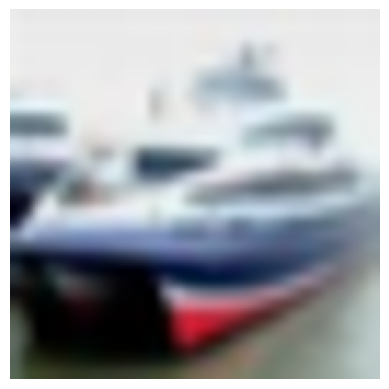

In [26]:
visualize_tensor_as_rgb(image)

In [27]:
class_name = dataset.classes[target]

In [50]:
class_name

'ship'

In [66]:
# use the first prompt template
# rand_index = np.random.randint(0, len(prompt_templates))
# text_of_target_class = prompt_templates[rand_index].format(class_name)
the_prompt = "A photo of " + str(dataset.classes[1])
print("the prompt" , the_prompt)
text_tokens = clip.tokenize(the_prompt).to(device)

noise = torch.randn(1, 100).to(device)
text_embedding = model.encode_text(text_tokens)
sec_emb = text_embedding.to(device)
gen_image, _ = generator(noise, sec_emb)
delta_im = gen_image

norm_type = "l2"
epsilon = 8
if norm_type == "l2":
    temp = torch.norm(delta_im.view(delta_im.shape[0], -1), dim=1).view(-1, 1, 1, 1)
    delta_im = delta_im * epsilon / temp
elif norm_type == "linf":
    delta_im = torch.clamp(delta_im, -epsilon / 255., epsilon / 255)  # torch.Size([16, 3, 256, 256])

delta_im = delta_im.to(image.device)
delta_im = F.interpolate(delta_im, (image.shape[-2], image.shape[-1]))

# add delta(noise) to image
images_adv = torch.clamp(image + delta_im, min=0, max=1)
images_adv_norm = clip_normalize(images_adv)

image_features_adv = model.encode_image(images_adv_norm)
    
image_features_adv /= image_features_adv.norm(dim=-1, keepdim=True)
logits_adv = 100. * image_features_adv @ zeroshot_weights

the prompt A photo of automobile


torch.Size([3, 224, 224])


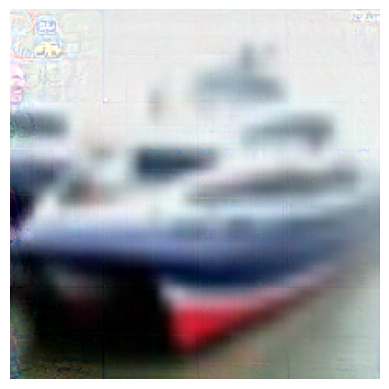

In [67]:
visualize_tensor_as_rgb(images_adv[0])

In [68]:
pred_adv = logits_adv.topk(1, 1, True, True)[1].t()

In [69]:
pred_adv

tensor([[9]], device='cuda:1')

In [70]:
dataset.classes[pred_adv]

'truck'

# About the dataset

In [1]:
from utils.load_data import load_class_dataset, load_pair_dataset

In [2]:
dataset = load_pair_dataset("nus-wide",64)

In [3]:
train_dataset = dataset['train']

In [4]:
dataset

{'train': <utils.load_data.CustomDataSet at 0x7f4c871392e0>,
 'test': <utils.load_data.CustomDataSet at 0x7f4c87139340>}

In [5]:
test_dataset = dataset['test']

In [6]:
train_dataset[0][1]

array([[49406,  1449,  1215,  2242,  1794,  3095,  6829,  3773,  6298,
         1012,  8231, 49407,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]])

In [7]:
print(len(test_dataset))

2000


In [8]:
text = "dog"

In [9]:
import clip

In [10]:
sec_text_token = clip.tokenize(text)

In [11]:
sec_text_token

tensor([[49406,  1929, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [12]:
sec_text_token.shape

torch.Size([1, 77])

In [13]:
the_word_token_num = sec_text_token[0][1]

In [14]:
the_word_token_num

tensor(1929, dtype=torch.int32)

In [15]:
print(len(train_dataset))

8000


In [16]:
test_dataset = dataset

In [17]:
for img,token,labels,idx in train_dataset:
    if the_word_token_num in token[0]:
        print("!")
        print(the_word_token_num)
        break
    print(token[0])
print("?")

[49406  1449  1215  2242  1794  3095  6829  3773  6298  1012  8231 49407
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
[49406   794  5352  6867 49407     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
[49406  5250  8700 49407     0     0     0     0     0     0

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [18]:
wiki_dataset = load_pair_dataset("wiki", 64)

In [19]:
wiki_train_dataset = wiki_dataset['train']

In [20]:
wiki_test_dataset = wiki_dataset['test']

In [21]:
print(len(wiki_train_dataset), len(wiki_test_dataset))

2157 462


In [22]:
from utils.load_data import load_class_dataset    

In [23]:
from utils.clip_util import clip_transform, clip_normalize

In [25]:
imagenet_dataset = load_class_dataset("ImageNet",None)

In [26]:
imagenet_train_dataset, imagenet_val_dataset = imagenet_dataset

In [27]:
dog_label_nums = []

In [28]:
for idx,class_name in enumerate(imagenet_train_dataset.classes):
    add_num = False
    if class_name[0] == 'hotdog':
        continue
    for each_name in class_name:
        if "dog" in each_name:
            add_num = True
            break
    if add_num:
        dog_label_nums.append(idx)
        print(class_name)

('Maltese dog', 'Maltese terrier', 'Maltese')
('Tibetan terrier', 'chrysanthemum dog')
('Old English sheepdog', 'bobtail')
('Shetland sheepdog', 'Shetland sheep dog', 'Shetland')
('German shepherd', 'German shepherd dog', 'German police dog', 'alsatian')
('Greater Swiss Mountain dog',)
('Bernese mountain dog',)
('French bulldog',)
('Eskimo dog', 'husky')
('dalmatian', 'coach dog', 'carriage dog')
('affenpinscher', 'monkey pinscher', 'monkey dog')
('pug', 'pug-dog')
('Newfoundland', 'Newfoundland dog')
('African hunting dog', 'hyena dog', 'Cape hunting dog', 'Lycaon pictus')
('dogsled', 'dog sled', 'dog sleigh')


In [29]:
dog_label_nums

[153, 200, 229, 230, 235, 238, 239, 245, 248, 251, 252, 254, 256, 275, 537]

In [30]:
the_dict = imagenet_train_dataset.class_to_idx

In [31]:
the_dict['hotdog']

934

In [32]:
for data in imagenet_train_dataset:
    print(data)
    break

(<PIL.Image.Image image mode=RGB size=250x250 at 0x7F4C3488B190>, 0)


In [33]:
from torchvision.utils import save_image

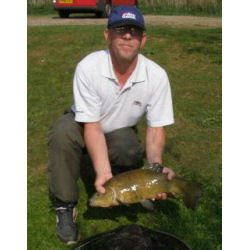

In [34]:
data[0]

In [35]:
import os

In [36]:
os.getcwd()

'/remote-home/songtianwei/research/unlearn_multimodal'

In [37]:
target_save_path = os.path.join(os.getcwd(),"data")

In [38]:
folder_name = "my-image-net_" + "dog"

In [39]:
output_dir = os.path.join(target_save_path, folder_name)

In [40]:
output_dir

'/remote-home/songtianwei/research/unlearn_multimodal/data/my-image-net_dog'

In [41]:
from pathlib import Path

In [42]:
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [43]:
from tqdm import tqdm

In [44]:
json_data = {}

In [45]:
for idx,(img,label) in tqdm(enumerate(imagenet_train_dataset)):
    if label in dog_label_nums:
        img_name = str(idx) + ".jpg"
        print(os.path.join(output_dir, img_name))
        img.save(os.path.join(output_dir, img_name))
        break
    break

0it [00:00, ?it/s]


In [46]:
# 定义要筛选的类别索引列表  
selected_classes = [51, 67, 84]  # 替换为你要筛选的类别索引  

In [48]:
from torch_geometric.data import InMemoryDataset

In [51]:
imagenet_train_dataset

Dataset ImageNet
    Number of datapoints: 1281167
    Root location: /remote-home/songtianwei/research/unlearn_multimodal/data/imagenet
    Split: train

In [60]:
folder_path = "/remote-home/songtianwei/research/unlearn_multimodal/data/dog_dataset/"

In [68]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms


dataset = ImageFolder(root=folder_path)

In [69]:
len(dataset)

12500

# 3.Test InfoNCE

In [76]:
from utils.nce import InfoNCE

In [97]:
loss_fn = InfoNCE(reduction='mean',negative_mode='unpaired')

In [98]:
import torch

In [109]:
# Tip the batch of query and positive_keys must be the same
query = torch.zeros((16,512))
positive_key = torch.ones((16,512))
negative_keys = torch.ones((10,512))

In [110]:
loss1 = loss_fn(query, positive_key, negative_keys)

In [111]:
loss2 = loss_fn(query, positive_key)

In [112]:
loss1

tensor(2.3979)

In [103]:
loss2

tensor(2.7726)

# 4.About the cifar-10 ten classes

In [153]:
collect_json_path = "/remote-home/songtianwei/research/clip_train/laion_dataset/cifar10.json"

In [154]:
import os
os.path.exists(collect_json_path)

True

In [155]:
import json

In [156]:
json_data = json.load(open(collect_json_path,'r'))

In [157]:
len(json_data)

46221

In [158]:
type(json_data)

list

In [159]:
json_data[0]

{'caption': '3d illustration of four engine commercial airplane isolated on white background',
 'image_path': '/remote-home/songtianwei/research/clip_train/laion_dataset/cifar10/airplane/00000/00000000005.jpg',
 'dataset': 'cifar10',
 'class': 'airplane'}

In [160]:
import matplotlib.pyplot as plt
import cv2

closeup image of wooden airplane miniature against little boy sitting in passenger seat during flight royalty free stock image


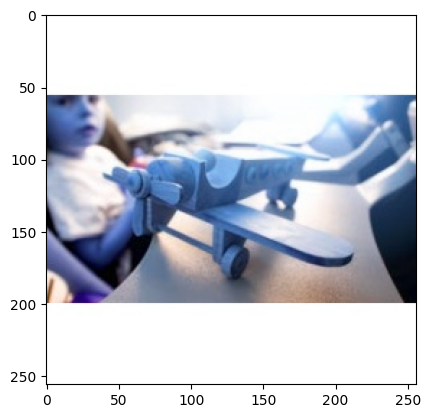

In [161]:
index = 5
plt.imshow(cv2.imread(json_data[index]['image_path']))
print(json_data[index]['caption'])

In [162]:
target_sample_list = []

In [163]:
from tqdm import tqdm

In [164]:
for sample in tqdm(json_data):
    if sample['dataset'] == 'cifar10' and sample['class'] != 'cat':
        target_sample_list.append(sample)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46221/46221 [00:00<00:00, 837896.39it/s]


In [165]:
len(target_sample_list)

42835

In [166]:
target_sample_list[0]

{'caption': '3d illustration of four engine commercial airplane isolated on white background',
 'image_path': '/remote-home/songtianwei/research/clip_train/laion_dataset/cifar10/airplane/00000/00000000005.jpg',
 'dataset': 'cifar10',
 'class': 'airplane'}

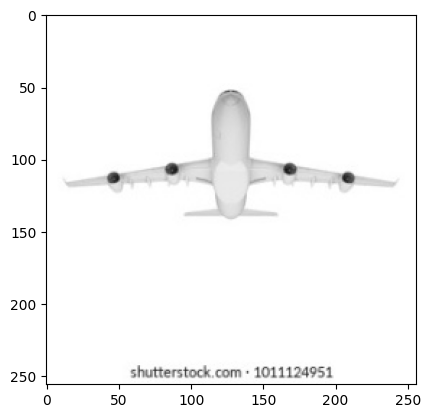

In [174]:
plt.imshow(cv2.imread(target_sample_list[0]['image_path']))

In [175]:
json.dump(target_sample_list,open("./data/laion-no-cat.json",'w'))

In [176]:
len(target_sample_list)

42835

# 5.About the train_generator min-max-clip-loss

In [127]:
json_path = "/remote-home/songtianwei/research/unlearn_multimodal/data/laion-cat.json"

In [128]:
from torch.utils.data import Dataset, DataLoader

In [129]:
from torchvision import transforms

In [130]:
import json
from PIL import Image

class myDataset(Dataset):
    def __init__(self,json_path,text_transform=None, img_transform=None):
        json_data = json.load(open(json_path,'r'))
        self.text_transform = text_transform
        self.img_transform = img_transform
    def __getitem__(self,idx):
        sample = self.json_data[idx]
        text, img_path = sample['caption'], sample['image_path']
        img = Image.open(img_path)
        img = img.convert('RGB')
        if self.text_transform:
            text = self.text_transform(text)
        if self.img_transform:
            img = self.img_transform(img)
        return text, img
    def __len__(self):
        return len(self.json_data)

In [131]:
myTrans = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
    ])

In [132]:
myDs = myDataset(json_path, img_transform = myTrans)

In [133]:
len(myDs)

3386

In [134]:
myDs[0][1].shape

torch.Size([3, 224, 224])

In [135]:
myDataloader = DataLoader(myDs, batch_size=8, shuffle=True,drop_last=True)

In [136]:
len_dataset = len(myDs)

# 6.About the supervised test 1

## 1.generate noise

In [1]:
import torch
from torchvision import transforms

import clip

from utils.data_utils import load_class_dataset
from utils.noise_utils import gen_perturbation
from models.model_gan_generator import NetG

In [2]:
myTrans = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.ToTensor()
    ])

In [3]:
trainDataset, testDataset = load_class_dataset('CIFAR10',myTrans)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
device = "cuda:0"

In [3]:
generator = NetG()
generator = generator.to(device)

In [4]:
cp_path = "/remote-home/songtianwei/research/unlearn_multimodal/output/train_g_unlearn/generator_epoch106_loss0.18612311780452728.pth"

In [5]:
checkpoint = torch.load(cp_path)

In [6]:
generator.load_state_dict(checkpoint)
generator.eval()

NetG(
  (conv_mask): Sequential(
    (0): Conv2d(512, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SynchronizedBatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(100, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (block0): G_Block(
    (c1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (affine0): affine(
      (batch_norm2d): SynchronizedBatchNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (fc_gamma): Sequential(
        (linear1): Linear(in_features=512, out_features=256, bias=True)
        (relu1): ReLU(inplace=True)
        (linear2): Linear(in_features=256, out_features=512, bias=True)
      )
      (fc_beta): Sequential(
        (linear1): Linear(in_features=512, out_features=256, bias=True)
        (rel

In [7]:
clip_version = 'ViT-B/16'
model, _ = clip.load(clip_version, device, jit=False)
model = model.float()
model = model.to(device) 

tokenizer = clip.tokenize

In [8]:
from utils.clip_util import prompt_templates

In [9]:
text_prompts = [prompt.format("cat") for prompt in prompt_templates]

In [10]:
text_prompts

['a photo of a cat.',
 'a blurry photo of a cat.',
 'a black and white photo of a cat.',
 'a low contrast photo of a cat.',
 'a high contrast photo of a cat.',
 'a bad photo of a cat.',
 'a good photo of a cat.',
 'a photo of a small cat.',
 'a photo of a big cat.',
 'a photo of the cat.',
 'a blurry photo of the cat.',
 'a black and white photo of the cat.',
 'a low contrast photo of the cat.',
 'a high contrast photo of the cat.',
 'a bad photo of the cat.',
 'a good photo of the cat.',
 'a photo of the small cat.',
 'a photo of the big cat.']

In [11]:
text_tokens = tokenizer(text_prompts).to(device)

In [12]:
text_embedding = model.encode_text(text_tokens)

In [13]:
noise_shape = (32,3,32,32)

In [18]:
noise_list = []
from tqdm import tqdm
for i in tqdm(range(5000//noise_shape[0] + 1)):
    delta_im = gen_perturbation(generator, text_embedding[0], noise_shape, args=None)
    noise_list.append(delta_im)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.69it/s]


In [26]:
noise = torch.concat(noise_list)
noise = noise[:5000]
noise.shape

torch.Size([5000, 3, 32, 32])

In [24]:
from utils.noise_utils import save_noise

In [25]:
save_noise(noise, "/remote-home/songtianwei/research/unlearn_multimodal/output/train_g_unlearn/cat_noise.pt")

In [22]:
delta_im.shape

torch.Size([32, 3, 32, 32])

In [4]:
tgt_save_path = "/remote-home/songtianwei/research/unlearn_multimodal/output/train_g_unlearn/cat_noise.pt"

In [5]:
torch.save(delta_im.detach().cpu(), tgt_save_path)

NameError: name 'delta_im' is not defined

In [6]:
from utils.ue_util import AverageMeter
from models.ResNet import ResNet18
from torch.utils.data import DataLoader
from tqdm import tqdm
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

base_model = ResNet18()

In [7]:
clean_train_loader = DataLoader(dataset=trainDataset, batch_size=512,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=12)
clean_test_loader = DataLoader(dataset=testDataset, batch_size=512,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=12)

In [8]:
# 正常训练
model = ResNet18()
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

unlearnable_loader = DataLoader(dataset=trainDataset, batch_size=128,
                                shuffle=True, pin_memory=True,
                                drop_last=False, num_workers=12)


for epoch in range(30):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(unlearnable_loader, total=len(unlearnable_loader))
    for images, labels in pbar:
        images, labels = images.cuda(), labels.cuda()
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    scheduler.step()
    # Eval
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    tqdm.write('Clean Accuracy %.2f\n' % (acc*100))
            

Acc 43.61 Loss: 1.55: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.47it/s]


Clean Accuracy 52.21



Acc 64.80 Loss: 0.98: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.61it/s]


Clean Accuracy 63.60



Acc 74.50 Loss: 0.73: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.84it/s]


Clean Accuracy 72.97



Acc 79.53 Loss: 0.58: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.38it/s]


Clean Accuracy 72.20



Acc 82.95 Loss: 0.49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.47it/s]


Clean Accuracy 71.75



Acc 85.86 Loss: 0.40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.05it/s]


Clean Accuracy 78.47



Acc 88.09 Loss: 0.34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.11it/s]


Clean Accuracy 78.92



Acc 89.59 Loss: 0.30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.47it/s]


Clean Accuracy 77.35



Acc 90.93 Loss: 0.26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.13it/s]


Clean Accuracy 76.76



Acc 91.85 Loss: 0.23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.97it/s]


Clean Accuracy 76.10



Acc 93.05 Loss: 0.20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.42it/s]


Clean Accuracy 76.26



Acc 94.43 Loss: 0.16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.26it/s]


Clean Accuracy 82.16



Acc 95.15 Loss: 0.14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.46it/s]


Clean Accuracy 80.52



Acc 96.10 Loss: 0.11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.98it/s]


Clean Accuracy 80.71



Acc 96.60 Loss: 0.10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.30it/s]


Clean Accuracy 79.72



Acc 97.37 Loss: 0.08: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.32it/s]


Clean Accuracy 82.60



Acc 98.45 Loss: 0.05: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.28it/s]


Clean Accuracy 83.73



Acc 99.22 Loss: 0.03: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.94it/s]


Clean Accuracy 83.68



Acc 99.86 Loss: 0.01: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.18it/s]


Clean Accuracy 86.70



Acc 99.99 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.22it/s]


Clean Accuracy 87.61



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.15it/s]


Clean Accuracy 87.78



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:13<00:00, 29.78it/s]


Clean Accuracy 87.85



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.12it/s]


Clean Accuracy 88.04



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.47it/s]


Clean Accuracy 88.02



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.07it/s]


Clean Accuracy 88.11



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:13<00:00, 29.89it/s]


Clean Accuracy 88.05



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.16it/s]


Clean Accuracy 88.06



Acc 100.00 Loss: 0.00:  27%|██████████████████████████████                                                                                  | 105/391 [00:04<00:11, 23.90it/s]


KeyboardInterrupt: 

In [6]:
trainDataset.class_to_idx['ship']

8

In [7]:
trainDataset.class_to_idx['cat']

3

In [9]:
tgt_save_path = "/remote-home/songtianwei/research/unlearn_multimodal/output/train_g_unlearn/cat_noise.pt"

In [10]:
noise = torch.load(tgt_save_path)

In [11]:
noise = transforms.Resize((32,32))(noise)

/remote-home/songtianwei/conda/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [12]:
noise.shape

torch.Size([32, 3, 32, 32])

In [20]:
device = 'cuda:0'

In [21]:
# 猫类别加入噪声
model = ResNet18()
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

unlearnable_loader = DataLoader(dataset=trainDataset, batch_size=128,
                                shuffle=True, pin_memory=True,
                                drop_last=False, num_workers=12)


for epoch in range(30):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(unlearnable_loader, total=len(unlearnable_loader))
    for images, labels in pbar:
        images, labels = images.cuda(), labels.cuda()
        the_noise = torch.zeros_like(images)
        indices_of_cat = torch.where(labels == 3)[0]
        the_noise[indices_of_cat] += noise[0].to(device)
        images = images + the_noise
        images = torch.clamp(images,0,1)
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    scheduler.step()
    # Eval
    model.eval()
    correct, total = 0, 0
    cat_correct, cat_total = 0,0
    cat_label = 3
    ship_label = 8
    ship_correct, ship_total = 0,0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            cat_total += (labels == cat_label).sum().item()
            cat_correct += ((predicted == labels) & (labels == cat_label)).sum().item()

            ship_total += (labels == ship_label).sum().item()
            ship_correct += ((predicted == labels) & (labels == ship_label)).sum().item()
    acc = correct / total
    cat_acc = cat_correct / cat_total
    ship_acc = ship_correct / ship_total
    tqdm.write('Clean Accuracy %.2f | Cat acc %.2f ,  Cat correct %d, Cat Total %d | Ship acc %.2f ,  Ship correct %d, Ship Total %d \n'
               % (acc*100, cat_acc *100, cat_correct, cat_total , ship_acc *100, ship_correct, ship_total))

Acc 41.36 Loss: 1.61: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.78it/s]


Clean Accuracy 51.10 | Cat acc 23.70 ,  Cat correct 237, Cat Total 1000 | Ship acc 67.30 ,  Ship correct 673, Ship Total 1000 



Acc 66.02 Loss: 0.96: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.51it/s]


Clean Accuracy 60.69 | Cat acc 2.10 ,  Cat correct 21, Cat Total 1000 | Ship acc 60.60 ,  Ship correct 606, Ship Total 1000 



Acc 78.88 Loss: 0.60: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.19it/s]


Clean Accuracy 67.56 | Cat acc 0.80 ,  Cat correct 8, Cat Total 1000 | Ship acc 73.10 ,  Ship correct 731, Ship Total 1000 



Acc 84.32 Loss: 0.45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.74it/s]


Clean Accuracy 69.75 | Cat acc 0.20 ,  Cat correct 2, Cat Total 1000 | Ship acc 92.60 ,  Ship correct 926, Ship Total 1000 



Acc 87.34 Loss: 0.36: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.01it/s]


Clean Accuracy 69.18 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 92.40 ,  Ship correct 924, Ship Total 1000 



Acc 89.66 Loss: 0.30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.57it/s]


Clean Accuracy 72.58 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 88.20 ,  Ship correct 882, Ship Total 1000 



Acc 91.31 Loss: 0.25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.98it/s]


Clean Accuracy 73.05 | Cat acc 0.30 ,  Cat correct 3, Cat Total 1000 | Ship acc 86.00 ,  Ship correct 860, Ship Total 1000 



Acc 92.51 Loss: 0.21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.82it/s]


Clean Accuracy 73.41 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 91.00 ,  Ship correct 910, Ship Total 1000 



Acc 93.83 Loss: 0.18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.80it/s]


Clean Accuracy 59.97 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 86.10 ,  Ship correct 861, Ship Total 1000 



Acc 94.36 Loss: 0.16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.45it/s]


Clean Accuracy 72.75 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 88.10 ,  Ship correct 881, Ship Total 1000 



Acc 95.25 Loss: 0.14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.90it/s]


Clean Accuracy 71.28 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 80.90 ,  Ship correct 809, Ship Total 1000 



Acc 95.91 Loss: 0.12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.62it/s]


Clean Accuracy 75.68 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 79.10 ,  Ship correct 791, Ship Total 1000 



Acc 96.57 Loss: 0.10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.99it/s]


Clean Accuracy 74.37 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 73.50 ,  Ship correct 735, Ship Total 1000 



Acc 97.07 Loss: 0.09: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.68it/s]


Clean Accuracy 74.63 | Cat acc 0.10 ,  Cat correct 1, Cat Total 1000 | Ship acc 91.70 ,  Ship correct 917, Ship Total 1000 



Acc 97.62 Loss: 0.07: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.87it/s]


Clean Accuracy 76.50 | Cat acc 0.10 ,  Cat correct 1, Cat Total 1000 | Ship acc 87.30 ,  Ship correct 873, Ship Total 1000 



Acc 98.67 Loss: 0.04: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.84it/s]


Clean Accuracy 74.64 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 75.00 ,  Ship correct 750, Ship Total 1000 



Acc 98.73 Loss: 0.04: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.70it/s]


Clean Accuracy 74.66 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 91.30 ,  Ship correct 913, Ship Total 1000 



Acc 99.34 Loss: 0.02: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.71it/s]


Clean Accuracy 77.59 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 88.50 ,  Ship correct 885, Ship Total 1000 



Acc 99.76 Loss: 0.01: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.78it/s]


Clean Accuracy 80.29 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 93.70 ,  Ship correct 937, Ship Total 1000 



Acc 99.98 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.79it/s]


Clean Accuracy 80.92 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 93.60 ,  Ship correct 936, Ship Total 1000 



Acc 100.00 Loss: 0.00:  34%|██████████████████████████████████████                                                                          | 133/391 [00:05<00:10, 25.55it/s]


KeyboardInterrupt: 

In [28]:
random_noise = torch.rand_like(noise) - torch.full(noise.shape, 0.5)
random_noise = torch.clamp(random_noise,-8.0/255,8.0/255)

In [29]:
random_noise

tensor([[[[-0.0314, -0.0314,  0.0314,  ..., -0.0314, -0.0314, -0.0314],
          [ 0.0314, -0.0314, -0.0314,  ...,  0.0314, -0.0314, -0.0314],
          [-0.0314, -0.0314,  0.0314,  ..., -0.0314, -0.0314,  0.0314],
          ...,
          [ 0.0314,  0.0314,  0.0314,  ...,  0.0314,  0.0314, -0.0031],
          [-0.0314, -0.0314, -0.0314,  ..., -0.0314, -0.0314, -0.0314],
          [-0.0314, -0.0314,  0.0314,  ..., -0.0314, -0.0314, -0.0314]],

         [[ 0.0250,  0.0314,  0.0314,  ..., -0.0314,  0.0314, -0.0314],
          [ 0.0314,  0.0314, -0.0314,  ...,  0.0100,  0.0314, -0.0314],
          [-0.0314, -0.0314, -0.0314,  ..., -0.0314, -0.0314,  0.0314],
          ...,
          [ 0.0314,  0.0314, -0.0314,  ..., -0.0314,  0.0314, -0.0314],
          [-0.0314, -0.0314, -0.0314,  ..., -0.0314, -0.0314,  0.0314],
          [ 0.0314,  0.0314, -0.0314,  ...,  0.0314, -0.0235, -0.0314]],

         [[ 0.0314, -0.0314, -0.0314,  ..., -0.0314,  0.0314, -0.0314],
          [ 0.0314,  0.0314, -

In [ ]:
# 猫类别加入固定随机噪声
model = ResNet18()
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

unlearnable_loader = DataLoader(dataset=trainDataset, batch_size=128,
                                shuffle=True, pin_memory=True,
                                drop_last=False, num_workers=12)


for epoch in range(30):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(unlearnable_loader, total=len(unlearnable_loader))
    for images, labels in pbar:
        images, labels = images.cuda(), labels.cuda()
        the_noise = torch.zeros_like(images)
        indices_of_cat = torch.where(labels == 3)[0]
        the_noise[indices_of_cat] += random_noise[0].to(device)
        images = images + the_noise
        images = torch.clamp(images,0,1)
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    scheduler.step()
    # Eval
    model.eval()
    correct, total = 0, 0
    cat_correct, cat_total = 0,0
    cat_label = 3
    ship_label = 8
    ship_correct, ship_total = 0,0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            cat_total += (labels == cat_label).sum().item()
            cat_correct += ((predicted == labels) & (labels == cat_label)).sum().item()

            ship_total += (labels == ship_label).sum().item()
            ship_correct += ((predicted == labels) & (labels == ship_label)).sum().item()
    acc = correct / total
    cat_acc = cat_correct / cat_total
    ship_acc = ship_correct / ship_total
    tqdm.write('Clean Accuracy %.2f | Cat acc %.2f ,  Cat correct %d, Cat Total %d | Ship acc %.2f ,  Ship correct %d, Ship Total %d \n'
               % (acc*100, cat_acc *100, cat_correct, cat_total , ship_acc *100, ship_correct, ship_total))

Acc 41.26 Loss: 1.62: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.57it/s]


Clean Accuracy 49.22 | Cat acc 47.00 ,  Cat correct 470, Cat Total 1000 | Ship acc 66.00 ,  Ship correct 660, Ship Total 1000 



Acc 69.89 Loss: 0.85: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.17it/s]


Clean Accuracy 62.74 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 89.10 ,  Ship correct 891, Ship Total 1000 



Acc 79.33 Loss: 0.59: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.86it/s]


Clean Accuracy 66.64 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 81.10 ,  Ship correct 811, Ship Total 1000 



Acc 84.16 Loss: 0.46: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.60it/s]


Clean Accuracy 71.04 | Cat acc 0.10 ,  Cat correct 1, Cat Total 1000 | Ship acc 87.90 ,  Ship correct 879, Ship Total 1000 



Acc 87.28 Loss: 0.37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.93it/s]


Clean Accuracy 72.23 | Cat acc 0.10 ,  Cat correct 1, Cat Total 1000 | Ship acc 88.90 ,  Ship correct 889, Ship Total 1000 



Acc 89.05 Loss: 0.32: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.98it/s]


Clean Accuracy 73.52 | Cat acc 0.20 ,  Cat correct 2, Cat Total 1000 | Ship acc 75.90 ,  Ship correct 759, Ship Total 1000 



Acc 90.94 Loss: 0.27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.11it/s]


Clean Accuracy 71.28 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 91.30 ,  Ship correct 913, Ship Total 1000 



Acc 92.06 Loss: 0.23: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.04it/s]


Clean Accuracy 73.60 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 92.00 ,  Ship correct 920, Ship Total 1000 



Acc 93.56 Loss: 0.18:  64%|████████████████████████████████████████████████████████████████████████▊                                        | 252/391 [00:08<00:04, 34.00it/s]

In [13]:
noise[0].eq(noise[1])

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [14]:
noise[0]

tensor([[[-0.0297, -0.0245, -0.0112,  ..., -0.0180,  0.0384,  0.0144],
         [-0.0207, -0.0063, -0.0174,  ...,  0.0140, -0.0527,  0.0938],
         [ 0.0289,  0.0104, -0.0267,  ...,  0.0107,  0.0130, -0.0278],
         ...,
         [ 0.0378, -0.0294, -0.0731,  ..., -0.0126, -0.0249, -0.0287],
         [-0.0073, -0.0145, -0.0377,  ..., -0.0008, -0.0145, -0.0246],
         [-0.0250, -0.0409,  0.0046,  ...,  0.0038, -0.0219, -0.0022]],

        [[ 0.0005, -0.0194, -0.0083,  ..., -0.0230,  0.0144,  0.0171],
         [-0.0223, -0.0018, -0.0240,  ...,  0.0023, -0.0348,  0.0292],
         [ 0.0125,  0.0045, -0.0394,  ...,  0.0079,  0.0116, -0.0257],
         ...,
         [-0.0197, -0.0026, -0.0557,  ..., -0.0285, -0.0141, -0.0467],
         [ 0.0012,  0.0063, -0.0222,  ...,  0.0123, -0.0239, -0.0138],
         [-0.0078, -0.0384,  0.0253,  ...,  0.0133, -0.0157,  0.0123]],

        [[-0.0220, -0.0352, -0.0146,  ...,  0.0083, -0.0368,  0.0229],
         [-0.0555,  0.0008, -0.0145,  ...,  0

In [15]:
torch.randint(0, 32, (1,))

tensor([24])

In [16]:
torch.randint(0,32,(len([1,2,3]),))

tensor([11, 14, 25])

In [17]:
import matplotlib.pyplot as plt

In [18]:
from torchvision.utils import save_image

In [21]:
# 猫类别加入非固定的不可学噪声
model = ResNet18()
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

unlearnable_loader = DataLoader(dataset=trainDataset, batch_size=128,
                                shuffle=True, pin_memory=True,
                                drop_last=False, num_workers=12)


for epoch in range(30):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(unlearnable_loader, total=len(unlearnable_loader))
    for images, labels in pbar:
        images, labels = images.cuda(), labels.cuda()
        the_noise = torch.zeros_like(images)
        indices_of_cat = torch.where(labels == 3)[0]
        noise_indices = torch.randint(0,32,(len(indices_of_cat),))
        the_noise[indices_of_cat] = noise[noise_indices].to(device)
        images = images + the_noise
        images = torch.clamp(images,0,1)
        # save_image(images,"attack_cat.jpg")
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
        
    scheduler.step()
    # Eval
    model.eval()
    correct, total = 0, 0
    cat_correct, cat_total = 0,0
    cat_label = 3
    ship_label = 8
    ship_correct, ship_total = 0,0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            cat_total += (labels == cat_label).sum().item()
            cat_correct += ((predicted == labels) & (labels == cat_label)).sum().item()

            ship_total += (labels == ship_label).sum().item()
            ship_correct += ((predicted == labels) & (labels == ship_label)).sum().item()
    acc = correct / total
    cat_acc = cat_correct / cat_total
    ship_acc = ship_correct / ship_total
    tqdm.write('Clean Accuracy %.2f | Cat acc %.2f ,  Cat correct %d, Cat Total %d | Ship acc %.2f ,  Ship correct %d, Ship Total %d \n'
               % (acc*100, cat_acc *100, cat_correct, cat_total , ship_acc *100, ship_correct, ship_total))

Acc 39.95 Loss: 1.67: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.58it/s]


Clean Accuracy 45.45 | Cat acc 24.00 ,  Cat correct 240, Cat Total 1000 | Ship acc 57.10 ,  Ship correct 571, Ship Total 1000 



Acc 66.68 Loss: 0.94: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.55it/s]


Clean Accuracy 58.93 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 72.80 ,  Ship correct 728, Ship Total 1000 



Acc 78.84 Loss: 0.61: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.37it/s]


Clean Accuracy 65.35 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 72.70 ,  Ship correct 727, Ship Total 1000 



Acc 83.80 Loss: 0.47: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.02it/s]


Clean Accuracy 70.90 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 87.20 ,  Ship correct 872, Ship Total 1000 



Acc 87.06 Loss: 0.37: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.04it/s]


Clean Accuracy 71.40 | Cat acc 0.10 ,  Cat correct 1, Cat Total 1000 | Ship acc 90.60 ,  Ship correct 906, Ship Total 1000 



Acc 89.24 Loss: 0.31: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.74it/s]


Clean Accuracy 69.22 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 86.50 ,  Ship correct 865, Ship Total 1000 



Acc 90.80 Loss: 0.27: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.11it/s]


Clean Accuracy 73.14 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 79.20 ,  Ship correct 792, Ship Total 1000 



Acc 92.50 Loss: 0.22: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.89it/s]


Clean Accuracy 71.27 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 92.60 ,  Ship correct 926, Ship Total 1000 



Acc 93.16 Loss: 0.20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.93it/s]


Clean Accuracy 75.99 | Cat acc 0.40 ,  Cat correct 4, Cat Total 1000 | Ship acc 87.00 ,  Ship correct 870, Ship Total 1000 



Acc 94.23 Loss: 0.17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.93it/s]


Clean Accuracy 73.30 | Cat acc 0.10 ,  Cat correct 1, Cat Total 1000 | Ship acc 84.80 ,  Ship correct 848, Ship Total 1000 



Acc 94.98 Loss: 0.15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.77it/s]


Clean Accuracy 74.68 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 77.40 ,  Ship correct 774, Ship Total 1000 



Acc 95.82 Loss: 0.12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.41it/s]


Clean Accuracy 68.53 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 92.40 ,  Ship correct 924, Ship Total 1000 



Acc 96.12 Loss: 0.11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.72it/s]


Clean Accuracy 71.00 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 91.30 ,  Ship correct 913, Ship Total 1000 



Acc 96.87 Loss: 0.09: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.64it/s]


Clean Accuracy 74.52 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 82.10 ,  Ship correct 821, Ship Total 1000 



Acc 97.74 Loss: 0.07: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.91it/s]


Clean Accuracy 74.39 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 91.60 ,  Ship correct 916, Ship Total 1000 



Acc 98.33 Loss: 0.05: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:13<00:00, 29.32it/s]


Clean Accuracy 76.56 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 86.80 ,  Ship correct 868, Ship Total 1000 



Acc 98.81 Loss: 0.04: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.75it/s]


Clean Accuracy 74.73 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 92.60 ,  Ship correct 926, Ship Total 1000 



Acc 99.32 Loss: 0.02: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.02it/s]


Clean Accuracy 77.83 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 89.40 ,  Ship correct 894, Ship Total 1000 



Acc 99.75 Loss: 0.01: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.91it/s]


Clean Accuracy 79.85 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 88.80 ,  Ship correct 888, Ship Total 1000 



Acc 99.95 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.94it/s]


Clean Accuracy 80.86 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 91.40 ,  Ship correct 914, Ship Total 1000 



Acc 99.99 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.74it/s]


Clean Accuracy 81.12 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 91.90 ,  Ship correct 919, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.56it/s]


Clean Accuracy 81.25 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 92.40 ,  Ship correct 924, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.90it/s]


Clean Accuracy 81.27 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 91.80 ,  Ship correct 918, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.62it/s]


Clean Accuracy 81.32 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 92.00 ,  Ship correct 920, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.89it/s]


Clean Accuracy 81.35 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 92.20 ,  Ship correct 922, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.65it/s]


Clean Accuracy 81.26 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 92.00 ,  Ship correct 920, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.64it/s]


Clean Accuracy 81.38 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 91.90 ,  Ship correct 919, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.19it/s]


Clean Accuracy 81.42 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 92.30 ,  Ship correct 923, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.01it/s]


Clean Accuracy 81.50 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 91.40 ,  Ship correct 914, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.62it/s]


Clean Accuracy 81.46 | Cat acc 0.00 ,  Cat correct 0, Cat Total 1000 | Ship acc 92.30 ,  Ship correct 923, Ship Total 1000 



# 7.About the supervised test - 2

In [1]:
import torch

from utils.data_utils import load_poison_dataset, load_class_dataset

In [2]:
noise = torch.load("/remote-home/songtianwei/research/unlearn_multimodal/output/train_g_unlearn/cat_noise.pt")

In [3]:
from torchvision import transforms

myTrans = transforms.Compose([
    transforms.ToTensor()
    ])

In [4]:
ue_train_cifar10, cifar_test = load_poison_dataset("cifar10", noise, myTrans)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
clean_train_cifar10, cifar_test = load_class_dataset("CIFAR10", myTrans)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
from test_supervised import test_supervised

### 1.Normal train

原始在cifar-10上训练

In [7]:
test_supervised(clean_train_cifar10, cifar_test)

Acc 37.51 Loss: 1.83: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.07it/s]


Clean Accuracy 33.14 | Cat acc 34.60 ,  Cat correct 346, Cat Total 1000 | Ship acc 18.40 ,  Ship correct 184, Ship Total 1000 



Acc 59.29 Loss: 1.12: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.01it/s]


Clean Accuracy 47.37 | Cat acc 26.00 ,  Cat correct 260, Cat Total 1000 | Ship acc 33.60 ,  Ship correct 336, Ship Total 1000 



Acc 69.61 Loss: 0.85: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.00it/s]


Clean Accuracy 55.45 | Cat acc 46.90 ,  Cat correct 469, Cat Total 1000 | Ship acc 49.00 ,  Ship correct 490, Ship Total 1000 



Acc 76.57 Loss: 0.66: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  8.94it/s]


Clean Accuracy 64.27 | Cat acc 66.30 ,  Cat correct 663, Cat Total 1000 | Ship acc 70.60 ,  Ship correct 706, Ship Total 1000 



Acc 81.31 Loss: 0.53: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.11it/s]


Clean Accuracy 67.10 | Cat acc 71.10 ,  Cat correct 711, Cat Total 1000 | Ship acc 78.40 ,  Ship correct 784, Ship Total 1000 



Acc 84.38 Loss: 0.44: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  8.99it/s]


Clean Accuracy 73.53 | Cat acc 65.30 ,  Cat correct 653, Cat Total 1000 | Ship acc 62.00 ,  Ship correct 620, Ship Total 1000 



Acc 87.53 Loss: 0.35: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  8.99it/s]


Clean Accuracy 67.14 | Cat acc 74.20 ,  Cat correct 742, Cat Total 1000 | Ship acc 44.20 ,  Ship correct 442, Ship Total 1000 



Acc 88.89 Loss: 0.31: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.02it/s]


Clean Accuracy 68.93 | Cat acc 71.30 ,  Cat correct 713, Cat Total 1000 | Ship acc 57.00 ,  Ship correct 570, Ship Total 1000 



Acc 91.22 Loss: 0.25: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.84it/s]


Clean Accuracy 66.76 | Cat acc 74.00 ,  Cat correct 740, Cat Total 1000 | Ship acc 55.50 ,  Ship correct 555, Ship Total 1000 



Acc 93.14 Loss: 0.19: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.01it/s]


Clean Accuracy 71.50 | Cat acc 85.40 ,  Cat correct 854, Cat Total 1000 | Ship acc 78.20 ,  Ship correct 782, Ship Total 1000 



Acc 94.83 Loss: 0.15: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.01it/s]


Clean Accuracy 71.05 | Cat acc 91.20 ,  Cat correct 912, Cat Total 1000 | Ship acc 67.20 ,  Ship correct 672, Ship Total 1000 



Acc 96.56 Loss: 0.10: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.05it/s]


Clean Accuracy 74.71 | Cat acc 74.50 ,  Cat correct 745, Cat Total 1000 | Ship acc 87.60 ,  Ship correct 876, Ship Total 1000 



Acc 98.06 Loss: 0.06: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.04it/s]


Clean Accuracy 76.59 | Cat acc 72.50 ,  Cat correct 725, Cat Total 1000 | Ship acc 83.80 ,  Ship correct 838, Ship Total 1000 



Acc 99.01 Loss: 0.03: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.02it/s]


Clean Accuracy 81.72 | Cat acc 54.90 ,  Cat correct 549, Cat Total 1000 | Ship acc 91.20 ,  Ship correct 912, Ship Total 1000 



Acc 99.76 Loss: 0.01: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.04it/s]


Clean Accuracy 83.56 | Cat acc 46.30 ,  Cat correct 463, Cat Total 1000 | Ship acc 92.30 ,  Ship correct 923, Ship Total 1000 



Acc 99.97 Loss: 0.00: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.00it/s]


Clean Accuracy 85.47 | Cat acc 72.30 ,  Cat correct 723, Cat Total 1000 | Ship acc 93.70 ,  Ship correct 937, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.04it/s]


Clean Accuracy 85.84 | Cat acc 70.90 ,  Cat correct 709, Cat Total 1000 | Ship acc 93.20 ,  Ship correct 932, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.01it/s]


Clean Accuracy 85.97 | Cat acc 71.20 ,  Cat correct 712, Cat Total 1000 | Ship acc 93.10 ,  Ship correct 931, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.05it/s]


Clean Accuracy 86.05 | Cat acc 71.20 ,  Cat correct 712, Cat Total 1000 | Ship acc 93.10 ,  Ship correct 931, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.00it/s]


Clean Accuracy 86.07 | Cat acc 71.30 ,  Cat correct 713, Cat Total 1000 | Ship acc 93.00 ,  Ship correct 930, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  8.98it/s]


Clean Accuracy 86.06 | Cat acc 71.30 ,  Cat correct 713, Cat Total 1000 | Ship acc 92.90 ,  Ship correct 929, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.03it/s]


Clean Accuracy 86.09 | Cat acc 71.20 ,  Cat correct 712, Cat Total 1000 | Ship acc 92.90 ,  Ship correct 929, Ship Total 1000 



Acc 100.00 Loss: 0.00:  51%|███████████████████████████████████████▎                                     | 50/98 [00:06<00:04, 10.32it/s]Exception in thread Thread-50:
Traceback (most recent call last):
  File "/remote-home/songtianwei/conda/lib/python3.9/threading.py", line 954, in _bootstrap_inner
    self.run()
  File "/remote-home/songtianwei/conda/lib/python3.9/threading.py", line 892, in run
    self._target(*self._args, **self._kwargs)
  File "/remote-home/songtianwei/conda/lib/python3.9/site-packages/torch/utils/data/_utils/pin_memory.py", line 51, in _pin_memory_loop
    do_one_step()
  File "/remote-home/songtianwei/conda/lib/python3.9/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/remote-home/songtianwei/conda/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/remote-home/songtianwei/conda/lib/python3.9/site-packages/torch/mult

KeyboardInterrupt: 

### 2.Poison Train

使用generator生成5000个噪声，prompt为 " a photo of a cat " ，经过clip tokenizer, encode text ,输入到generator中，输入还有随机噪音。生成噪音，resize到[32,32]

In [8]:
test_supervised(ue_train_cifar10, cifar_test)

Acc 36.37 Loss: 1.86: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.03it/s]


Clean Accuracy 32.78 | Cat acc 26.10 ,  Cat correct 261, Cat Total 1000 | Ship acc 47.20 ,  Ship correct 472, Ship Total 1000 



Acc 56.40 Loss: 1.20: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.11it/s]


Clean Accuracy 45.37 | Cat acc 11.60 ,  Cat correct 116, Cat Total 1000 | Ship acc 31.00 ,  Ship correct 310, Ship Total 1000 



Acc 68.73 Loss: 0.88: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  8.91it/s]


Clean Accuracy 49.46 | Cat acc 26.60 ,  Cat correct 266, Cat Total 1000 | Ship acc 76.00 ,  Ship correct 760, Ship Total 1000 



Acc 78.22 Loss: 0.63: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.06it/s]


Clean Accuracy 62.03 | Cat acc 59.20 ,  Cat correct 592, Cat Total 1000 | Ship acc 86.40 ,  Ship correct 864, Ship Total 1000 



Acc 85.18 Loss: 0.43: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.03it/s]


Clean Accuracy 69.72 | Cat acc 22.40 ,  Cat correct 224, Cat Total 1000 | Ship acc 75.90 ,  Ship correct 759, Ship Total 1000 



Acc 89.20 Loss: 0.31: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.02it/s]


Clean Accuracy 60.39 | Cat acc 3.40 ,  Cat correct 34, Cat Total 1000 | Ship acc 71.90 ,  Ship correct 719, Ship Total 1000 



Acc 90.77 Loss: 0.27: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.07it/s]


Clean Accuracy 63.46 | Cat acc 8.10 ,  Cat correct 81, Cat Total 1000 | Ship acc 62.80 ,  Ship correct 628, Ship Total 1000 



Acc 92.42 Loss: 0.22: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.85it/s]


Clean Accuracy 65.31 | Cat acc 0.60 ,  Cat correct 6, Cat Total 1000 | Ship acc 58.40 ,  Ship correct 584, Ship Total 1000 



Acc 94.80 Loss: 0.15: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  8.99it/s]


Clean Accuracy 69.19 | Cat acc 5.30 ,  Cat correct 53, Cat Total 1000 | Ship acc 82.50 ,  Ship correct 825, Ship Total 1000 



Acc 96.08 Loss: 0.11: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.03it/s]


Clean Accuracy 65.17 | Cat acc 0.20 ,  Cat correct 2, Cat Total 1000 | Ship acc 88.60 ,  Ship correct 886, Ship Total 1000 



Acc 97.49 Loss: 0.07: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.03it/s]


Clean Accuracy 68.02 | Cat acc 1.00 ,  Cat correct 10, Cat Total 1000 | Ship acc 67.00 ,  Ship correct 670, Ship Total 1000 



Acc 98.29 Loss: 0.05: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  8.96it/s]


Clean Accuracy 71.20 | Cat acc 2.20 ,  Cat correct 22, Cat Total 1000 | Ship acc 88.50 ,  Ship correct 885, Ship Total 1000 



Acc 99.20 Loss: 0.03: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.00it/s]


Clean Accuracy 76.54 | Cat acc 2.00 ,  Cat correct 20, Cat Total 1000 | Ship acc 94.90 ,  Ship correct 949, Ship Total 1000 



Acc 99.71 Loss: 0.01: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.47it/s]


Clean Accuracy 78.62 | Cat acc 2.00 ,  Cat correct 20, Cat Total 1000 | Ship acc 90.70 ,  Ship correct 907, Ship Total 1000 



Acc 99.96 Loss: 0.00: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.41it/s]


Clean Accuracy 79.37 | Cat acc 1.70 ,  Cat correct 17, Cat Total 1000 | Ship acc 91.60 ,  Ship correct 916, Ship Total 1000 



Acc 99.99 Loss: 0.00: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  8.99it/s]


Clean Accuracy 79.63 | Cat acc 2.20 ,  Cat correct 22, Cat Total 1000 | Ship acc 92.00 ,  Ship correct 920, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.77it/s]


Clean Accuracy 79.60 | Cat acc 2.40 ,  Cat correct 24, Cat Total 1000 | Ship acc 92.40 ,  Ship correct 924, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.41it/s]


Clean Accuracy 79.61 | Cat acc 2.20 ,  Cat correct 22, Cat Total 1000 | Ship acc 92.20 ,  Ship correct 922, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.44it/s]


Clean Accuracy 79.70 | Cat acc 2.20 ,  Cat correct 22, Cat Total 1000 | Ship acc 92.10 ,  Ship correct 921, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.42it/s]


Clean Accuracy 79.77 | Cat acc 2.20 ,  Cat correct 22, Cat Total 1000 | Ship acc 92.30 ,  Ship correct 923, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.40it/s]


Clean Accuracy 79.84 | Cat acc 2.20 ,  Cat correct 22, Cat Total 1000 | Ship acc 92.20 ,  Ship correct 922, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.48it/s]


Clean Accuracy 79.83 | Cat acc 2.20 ,  Cat correct 22, Cat Total 1000 | Ship acc 92.10 ,  Ship correct 921, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.47it/s]


Clean Accuracy 79.81 | Cat acc 2.10 ,  Cat correct 21, Cat Total 1000 | Ship acc 92.10 ,  Ship correct 921, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.46it/s]


Clean Accuracy 79.79 | Cat acc 2.10 ,  Cat correct 21, Cat Total 1000 | Ship acc 92.10 ,  Ship correct 921, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.41it/s]


Clean Accuracy 79.83 | Cat acc 2.00 ,  Cat correct 20, Cat Total 1000 | Ship acc 92.10 ,  Ship correct 921, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:11<00:00,  8.45it/s]


Clean Accuracy 79.86 | Cat acc 2.00 ,  Cat correct 20, Cat Total 1000 | Ship acc 92.10 ,  Ship correct 921, Ship Total 1000 



Acc 100.00 Loss: 0.00:  23%|██████████████████                                                           | 23/98 [00:04<00:14,  5.28it/s]


KeyboardInterrupt: 

### 3.使用直接的噪音添加上去

#### 3.1预处理生成噪音

In [32]:
checkpoint = torch.load("/remote-home/songtianwei/research/unlearn_multimodal/output/train_unlearn_noise/noise_epoch19_loss0.8868988156318665.pth")

In [33]:
noise = checkpoint['noise']

In [34]:
noise.shape

torch.Size([3386, 3, 224, 224])

In [35]:
import torch.nn.functional as F
from torchvision import transforms

# noise = F.interpolate(noise, (32,32))
noise = transforms.Resize((32,32))(noise)

/remote-home/songtianwei/conda/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [36]:
noise.shape

torch.Size([3386, 3, 32, 32])

In [37]:
noise[:(5000-noise.shape[0])].shape

torch.Size([1614, 3, 32, 32])

In [38]:
noise = torch.cat([noise,noise[:(5000-noise.shape[0])]],dim=0)

In [39]:
noise.shape

torch.Size([5000, 3, 32, 32])

In [40]:
tgt_save_path = "/remote-home/songtianwei/research/unlearn_multimodal/output/train_unlearn_noise/cat_noise.pt"

In [41]:
from utils.noise_utils import save_noise

save_noise(noise,tgt_save_path)

#### 3.2 测试

In [42]:
noise = torch.load("/remote-home/songtianwei/research/unlearn_multimodal/output/train_unlearn_noise/cat_noise.pt")

In [43]:
ue_train_cifar10, cifar_test = load_poison_dataset("cifar10", noise, myTrans)

Files already downloaded and verified
Files already downloaded and verified


In [44]:
test_supervised(ue_train_cifar10, cifar_test)

Acc 36.48 Loss: 1.80: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.53it/s]


Clean Accuracy 37.56 | Cat acc 49.30 ,  Cat correct 493, Cat Total 1000 | Ship acc 81.00 ,  Ship correct 810, Ship Total 1000 



Acc 57.78 Loss: 1.17: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.50it/s]


Clean Accuracy 55.77 | Cat acc 66.20 ,  Cat correct 662, Cat Total 1000 | Ship acc 55.10 ,  Ship correct 551, Ship Total 1000 



Acc 68.20 Loss: 0.89: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.44it/s]


Clean Accuracy 68.01 | Cat acc 59.80 ,  Cat correct 598, Cat Total 1000 | Ship acc 80.00 ,  Ship correct 800, Ship Total 1000 



Acc 75.78 Loss: 0.68: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.35it/s]


Clean Accuracy 69.40 | Cat acc 63.10 ,  Cat correct 631, Cat Total 1000 | Ship acc 81.00 ,  Ship correct 810, Ship Total 1000 



Acc 80.94 Loss: 0.54: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.48it/s]


Clean Accuracy 69.84 | Cat acc 69.90 ,  Cat correct 699, Cat Total 1000 | Ship acc 82.90 ,  Ship correct 829, Ship Total 1000 



Acc 84.47 Loss: 0.44: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.48it/s]


Clean Accuracy 72.77 | Cat acc 70.00 ,  Cat correct 700, Cat Total 1000 | Ship acc 62.10 ,  Ship correct 621, Ship Total 1000 



Acc 86.83 Loss: 0.37: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.42it/s]


Clean Accuracy 70.23 | Cat acc 64.60 ,  Cat correct 646, Cat Total 1000 | Ship acc 45.30 ,  Ship correct 453, Ship Total 1000 



Acc 89.91 Loss: 0.29: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:12<00:00,  7.55it/s]


Clean Accuracy 67.65 | Cat acc 83.80 ,  Cat correct 838, Cat Total 1000 | Ship acc 52.70 ,  Ship correct 527, Ship Total 1000 



Acc 91.97 Loss: 0.23: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.52it/s]


Clean Accuracy 72.11 | Cat acc 75.80 ,  Cat correct 758, Cat Total 1000 | Ship acc 75.80 ,  Ship correct 758, Ship Total 1000 



Acc 94.07 Loss: 0.17: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.46it/s]


Clean Accuracy 72.93 | Cat acc 71.40 ,  Cat correct 714, Cat Total 1000 | Ship acc 83.50 ,  Ship correct 835, Ship Total 1000 



Acc 95.88 Loss: 0.12: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.51it/s]


Clean Accuracy 74.40 | Cat acc 30.80 ,  Cat correct 308, Cat Total 1000 | Ship acc 82.70 ,  Ship correct 827, Ship Total 1000 



Acc 97.38 Loss: 0.08: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.48it/s]


Clean Accuracy 76.20 | Cat acc 52.90 ,  Cat correct 529, Cat Total 1000 | Ship acc 89.30 ,  Ship correct 893, Ship Total 1000 



Acc 98.23 Loss: 0.05: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.45it/s]


Clean Accuracy 79.70 | Cat acc 64.40 ,  Cat correct 644, Cat Total 1000 | Ship acc 93.40 ,  Ship correct 934, Ship Total 1000 



Acc 99.24 Loss: 0.03: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.37it/s]


Clean Accuracy 81.75 | Cat acc 73.70 ,  Cat correct 737, Cat Total 1000 | Ship acc 94.30 ,  Ship correct 943, Ship Total 1000 



Acc 99.82 Loss: 0.01: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.46it/s]


Clean Accuracy 83.13 | Cat acc 60.90 ,  Cat correct 609, Cat Total 1000 | Ship acc 93.50 ,  Ship correct 935, Ship Total 1000 



Acc 99.97 Loss: 0.00: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.50it/s]


Clean Accuracy 83.98 | Cat acc 63.20 ,  Cat correct 632, Cat Total 1000 | Ship acc 90.30 ,  Ship correct 903, Ship Total 1000 



Acc 99.97 Loss: 0.00: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.45it/s]


Clean Accuracy 84.13 | Cat acc 62.30 ,  Cat correct 623, Cat Total 1000 | Ship acc 92.10 ,  Ship correct 921, Ship Total 1000 



Acc 99.99 Loss: 0.00: 100%|██████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.47it/s]


Clean Accuracy 84.22 | Cat acc 62.30 ,  Cat correct 623, Cat Total 1000 | Ship acc 92.30 ,  Ship correct 923, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.48it/s]


Clean Accuracy 84.22 | Cat acc 62.10 ,  Cat correct 621, Cat Total 1000 | Ship acc 92.40 ,  Ship correct 924, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.44it/s]


Clean Accuracy 84.27 | Cat acc 61.90 ,  Cat correct 619, Cat Total 1000 | Ship acc 92.50 ,  Ship correct 925, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.40it/s]


Clean Accuracy 84.28 | Cat acc 61.60 ,  Cat correct 616, Cat Total 1000 | Ship acc 92.50 ,  Ship correct 925, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.47it/s]


Clean Accuracy 84.34 | Cat acc 61.80 ,  Cat correct 618, Cat Total 1000 | Ship acc 92.40 ,  Ship correct 924, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.47it/s]


Clean Accuracy 84.36 | Cat acc 61.80 ,  Cat correct 618, Cat Total 1000 | Ship acc 92.40 ,  Ship correct 924, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.45it/s]


Clean Accuracy 84.37 | Cat acc 61.90 ,  Cat correct 619, Cat Total 1000 | Ship acc 92.40 ,  Ship correct 924, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.52it/s]


Clean Accuracy 84.39 | Cat acc 61.90 ,  Cat correct 619, Cat Total 1000 | Ship acc 92.40 ,  Ship correct 924, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.48it/s]


Clean Accuracy 84.37 | Cat acc 61.90 ,  Cat correct 619, Cat Total 1000 | Ship acc 92.40 ,  Ship correct 924, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.52it/s]


Clean Accuracy 84.37 | Cat acc 61.80 ,  Cat correct 618, Cat Total 1000 | Ship acc 92.40 ,  Ship correct 924, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.37it/s]


Clean Accuracy 84.36 | Cat acc 61.70 ,  Cat correct 617, Cat Total 1000 | Ship acc 92.40 ,  Ship correct 924, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.47it/s]


Clean Accuracy 84.35 | Cat acc 61.60 ,  Cat correct 616, Cat Total 1000 | Ship acc 92.40 ,  Ship correct 924, Ship Total 1000 



Acc 100.00 Loss: 0.00: 100%|█████████████████████████████████████████████████████████████████████████████| 98/98 [00:13<00:00,  7.49it/s]


Clean Accuracy 84.35 | Cat acc 61.60 ,  Cat correct 616, Cat Total 1000 | Ship acc 92.40 ,  Ship correct 924, Ship Total 1000 



# 8.About the CLIP finetune - with singal modal

In [1]:
from train_downstream_solo import classify

In [2]:
from utils.clip_util import get_clip_model

In [3]:
clip = get_clip_model('ViT-B/16','cuda:0')

In [4]:
import torch

from utils.data_utils import load_poison_dataset, load_class_dataset, create_my_loader

In [5]:
noise = torch.load("/remote-home/songtianwei/research/unlearn_multimodal/output/train_g_unlearn/cat_noise.pt")

In [6]:
from torchvision import transforms

myTrans = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
    ])

In [7]:
ue_train_cifar10, cifar_test = load_poison_dataset("cifar10", noise, myTrans)
ue_trainloader , test_loader = create_my_loader(ue_train_cifar10, cifar_test)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
clean_train_cifar10, cifar_test = load_class_dataset("CIFAR10", myTrans)
clean_trainloader , test_loader = create_my_loader(clean_train_cifar10, cifar_test)

Files already downloaded and verified
Files already downloaded and verified


### 1. Finetune on cifar-10

In [ ]:
classify(clip, clean_trainloader, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.74it/s]


Clean Top1 Accuracy 8371.24 Top5 Acc 9914.95 | Cat acc 69.00 ,  Cat correct 690, Cat Total 1000 | Ship acc 86.70 ,  Ship correct 867, Ship Total 1000 

Epoch [1/20], Top1 train acc: 79.7754, Top1 test acc: 83.7124, Time: 416.2480


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.76it/s]


Clean Top1 Accuracy 8462.22 Top5 Acc 9917.92 | Cat acc 75.20 ,  Cat correct 752, Cat Total 1000 | Ship acc 87.80 ,  Ship correct 878, Ship Total 1000 

Epoch [2/20], Top1 train acc: 83.7776, Top1 test acc: 84.6222, Time: 397.3050


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.74it/s]


Clean Top1 Accuracy 8467.17 Top5 Acc 9930.78 | Cat acc 76.60 ,  Cat correct 766, Cat Total 1000 | Ship acc 89.70 ,  Ship correct 897, Ship Total 1000 

Epoch [3/20], Top1 train acc: 84.5688, Top1 test acc: 84.6717, Time: 397.1586


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.74it/s]


Clean Top1 Accuracy 8504.75 Top5 Acc 9933.74 | Cat acc 75.80 ,  Cat correct 758, Cat Total 1000 | Ship acc 89.60 ,  Ship correct 896, Ship Total 1000 

Epoch [4/20], Top1 train acc: 85.1770, Top1 test acc: 85.0475, Time: 397.2536


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.74it/s]


Clean Top1 Accuracy 8535.40 Top5 Acc 9930.78 | Cat acc 73.00 ,  Cat correct 730, Cat Total 1000 | Ship acc 90.40 ,  Ship correct 904, Ship Total 1000 

Epoch [5/20], Top1 train acc: 85.7165, Top1 test acc: 85.3540, Time: 397.4163


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.74it/s]


Clean Top1 Accuracy 8523.54 Top5 Acc 9932.75 | Cat acc 70.60 ,  Cat correct 706, Cat Total 1000 | Ship acc 93.30 ,  Ship correct 933, Ship Total 1000 

Epoch [6/20], Top1 train acc: 85.7661, Top1 test acc: 85.2354, Time: 397.0593


Acc 1470390.62 Loss: 0.48:  44%|██████████████████████████████▏                                      | 171/391 [02:54<03:42,  1.01s/it]

In [9]:
classify(clip, ue_trainloader, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:28<00:00,  2.75it/s]


Clean Top1 Accuracy 82.69 Top5 Acc 98.96 | Cat acc 58.20 ,  Cat correct 582, Cat Total 1000 | Ship acc 84.00 ,  Ship correct 840, Ship Total 1000 

Epoch [1/20], Top1 train acc: 80.5742, Top1 test acc: 82.6938, Time: 410.1063


Acc 74765.62 Loss: 0.53:   2%|██▌                                                                                                             | 9/391 [00:11<08:18,  1.30s/it]

KeyboardInterrupt



# 9.About the CLIP finetune 

### preprocess json dataset

In [4]:
import json

In [5]:
json_path = "/remote-home/songtianwei/research/unlearn_multimodal/data/laion-cat.json"
json_path = "/remote-home/songtianwei/research/unlearn_multimodal/data/laion-no-cat.json"

In [6]:
# 每个样本加个index

In [7]:
json_data = json.load(open(json_path,"r"))

In [8]:
for idx in range(len(json_data)):
    json_data[idx]['index'] = idx

In [9]:
print(json_data[1])

{'caption': "le garçon avec sa main court le modèle de l'avion dans le ciel image libre de droits", 'image_path': '/remote-home/songtianwei/research/clip_train/laion_dataset/cifar10/airplane/00000/00000000014.jpg', 'dataset': 'cifar10', 'class': 'airplane', 'index': 1}


In [10]:
json_save_path = "/remote-home/songtianwei/research/unlearn_multimodal/data/laion-cat-with-index.json"
json_save_path = "/remote-home/songtianwei/research/unlearn_multimodal/data/laion-no-cat.json"

In [11]:
json.dump(json_data,open(json_save_path,"w"))

### 1.Generate noise with generator

### 2.Test

In [1]:
from utils.data_utils import jsonPoisonDataset, To244TensorTrans, create_simple_loader
import torch

In [2]:
json_save_path = "/remote-home/songtianwei/research/unlearn_multimodal/data/laion-cat-with-index.json"
noise_path = "/remote-home/songtianwei/research/unlearn_multimodal/output/train_g_unlearn/cat_noise_ori.pt"

In [3]:
poisonDataset = jsonPoisonDataset(json_save_path, noise_path,img_transform= To244TensorTrans)

In [4]:
for data in poisonDataset:
    print(data[0])
    break

cat in pop art colors, colorful low poly design isolated on dark background with a white outline. animal portrait card.


In [5]:
train_loader = create_simple_loader(poisonDataset)

### 3.Finetune on all cifar-10 classes dataset

先执行下面两条语句

In [1]:
print('hello')

hello


In [2]:
from test_finetune_clip import run_default_experiment

In [3]:
import sys
sys.argv = ['run.py']

#### 1.说明：这个是使用ViT B/16的clip模型，在针对于cifar-10数据集上10个类别的图文对数据集上进行 finetune。然后使用cifar10测试zero-shot准确率

在所有类别数据集微调，猫类别加入不可学噪音

In [ ]:
run_default_experiment()

2024-01-16,22:33:28 | INFO | Creating model
2024-01-16,22:33:46 | INFO | Start training


Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.12it/s]


Start zero shot


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:49<00:00,  3.17it/s]

Top-1 accuracy: 90.8
Top-5 accuracy: 99.42999999999999
Target attack accuracy: 10.25
Cat accuracy: 0.843
Ship accuracy: 0.942
Zero shot result: top1: 90.8, top5: 99.42999999999999
{'zero-shot': {'top1': 90.8, 'top5': 99.42999999999999}}



/remote-home/songtianwei/conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/remote-home/songtianwei/conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to

Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 81.44it/s]


Start zero shot


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:41<00:00,  3.80it/s]

Top-1 accuracy: 81.72
Top-5 accuracy: 97.54
Target attack accuracy: 6.2
Cat accuracy: 0.975
Ship accuracy: 0.614
Zero shot result: top1: 81.72, top5: 97.54
{'zero-shot': {'top1': 81.72, 'top5': 97.54}}



2024-01-16,22:38:41 | INFO | Train Epoch: [1]  [  0/362]  eta: 0:18:34  lr: 0.000002  total_loss: 2.4812  time: 3.0790  data: 2.5760  max mem: 15453
2024-01-16,22:39:30 | INFO | Train Epoch: [1]  [100/362]  eta: 0:02:14  lr: 0.000002  total_loss: 1.0471  time: 0.4848  data: 0.0001  max mem: 15453
2024-01-16,22:40:19 | INFO | Train Epoch: [1]  [200/362]  eta: 0:01:20  lr: 0.000002  total_loss: 0.8008  time: 0.4865  data: 0.0001  max mem: 15453
2024-01-16,22:41:07 | INFO | Train Epoch: [1]  [300/362]  eta: 0:00:30  lr: 0.000002  total_loss: 1.3654  time: 0.4856  data: 0.0001  max mem: 15453
2024-01-16,22:41:37 | INFO | Train Epoch: [1]  [361/362]  eta: 0:00:00  lr: 0.000002  total_loss: 0.2267  time: 0.4679  data: 0.0001  max mem: 15453
2024-01-16,22:41:37 | INFO | Train Epoch: [1] Total time: 0:02:58 (0.4931 s / it)
2024-01-16,22:41:37 | INFO | Averaged stats: lr: 0.0000  total_loss: 1.3260


Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.96it/s]


Start zero shot


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:40<00:00,  3.84it/s]

Top-1 accuracy: 84.59
Top-5 accuracy: 98.29
Target attack accuracy: 7.75
Cat accuracy: 0.969
Ship accuracy: 0.782
Zero shot result: top1: 84.59, top5: 98.29
{'zero-shot': {'top1': 84.59, 'top5': 98.29}}



2024-01-16,22:42:25 | INFO | Train Epoch: [2]  [  0/362]  eta: 0:17:40  lr: 0.000002  total_loss: 2.3426  time: 2.9301  data: 2.4298  max mem: 15453
2024-01-16,22:43:14 | INFO | Train Epoch: [2]  [100/362]  eta: 0:02:14  lr: 0.000002  total_loss: 0.6228  time: 0.4874  data: 0.0001  max mem: 15455
2024-01-16,22:44:03 | INFO | Train Epoch: [2]  [200/362]  eta: 0:01:21  lr: 0.000002  total_loss: 0.4979  time: 0.4878  data: 0.0001  max mem: 15455
2024-01-16,22:44:51 | INFO | Train Epoch: [2]  [300/362]  eta: 0:00:30  lr: 0.000002  total_loss: 0.8478  time: 0.4871  data: 0.0001  max mem: 15455
2024-01-16,22:45:21 | INFO | Train Epoch: [2]  [361/362]  eta: 0:00:00  lr: 0.000002  total_loss: 0.0105  time: 0.4695  data: 0.0001  max mem: 15455
2024-01-16,22:45:21 | INFO | Train Epoch: [2] Total time: 0:02:58 (0.4943 s / it)
2024-01-16,22:45:21 | INFO | Averaged stats: lr: 0.0000  total_loss: 0.8414


Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.62it/s]


Start zero shot


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:41<00:00,  3.81it/s]

Top-1 accuracy: 84.69
Top-5 accuracy: 98.06
Target attack accuracy: 8.44
Cat accuracy: 0.941
Ship accuracy: 0.765
Zero shot result: top1: 84.69, top5: 98.06
{'zero-shot': {'top1': 84.69, 'top5': 98.06}}



2024-01-16,22:46:10 | INFO | Train Epoch: [3]  [  0/362]  eta: 0:21:15  lr: 0.000001  total_loss: 2.5535  time: 3.5237  data: 3.0290  max mem: 15455
2024-01-16,22:46:58 | INFO | Train Epoch: [3]  [100/362]  eta: 0:02:15  lr: 0.000001  total_loss: 0.3491  time: 0.4869  data: 0.0002  max mem: 15455
2024-01-16,22:47:47 | INFO | Train Epoch: [3]  [200/362]  eta: 0:01:21  lr: 0.000001  total_loss: 0.3076  time: 0.4876  data: 0.0001  max mem: 15455
2024-01-16,22:48:36 | INFO | Train Epoch: [3]  [300/362]  eta: 0:00:30  lr: 0.000001  total_loss: 0.4557  time: 0.4876  data: 0.0001  max mem: 15455
2024-01-16,22:49:05 | INFO | Train Epoch: [3]  [361/362]  eta: 0:00:00  lr: 0.000001  total_loss: 0.0044  time: 0.4692  data: 0.0001  max mem: 15455
2024-01-16,22:49:06 | INFO | Train Epoch: [3] Total time: 0:02:59 (0.4953 s / it)
2024-01-16,22:49:06 | INFO | Averaged stats: lr: 0.0000  total_loss: 0.5093


Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.72it/s]


Start zero shot


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:40<00:00,  3.85it/s]

Top-1 accuracy: 83.54
Top-5 accuracy: 97.64
Target attack accuracy: 8.41
Cat accuracy: 0.923
Ship accuracy: 0.742
Zero shot result: top1: 83.54, top5: 97.64
{'zero-shot': {'top1': 83.54, 'top5': 97.64}}



2024-01-16,22:49:54 | INFO | Train Epoch: [4]  [  0/362]  eta: 0:15:16  lr: 0.000001  total_loss: 2.8542  time: 2.5323  data: 2.0218  max mem: 15455
2024-01-16,22:50:43 | INFO | Train Epoch: [4]  [100/362]  eta: 0:02:13  lr: 0.000001  total_loss: 0.1864  time: 0.5007  data: 0.0002  max mem: 15455
2024-01-16,22:51:31 | INFO | Train Epoch: [4]  [200/362]  eta: 0:01:20  lr: 0.000001  total_loss: 0.1943  time: 0.4849  data: 0.0001  max mem: 15455
2024-01-16,22:52:20 | INFO | Train Epoch: [4]  [300/362]  eta: 0:00:30  lr: 0.000001  total_loss: 0.2203  time: 0.4843  data: 0.0001  max mem: 15455
2024-01-16,22:52:49 | INFO | Train Epoch: [4]  [361/362]  eta: 0:00:00  lr: 0.000001  total_loss: 0.0026  time: 0.4671  data: 0.0001  max mem: 15455
2024-01-16,22:52:49 | INFO | Train Epoch: [4] Total time: 0:02:58 (0.4921 s / it)
2024-01-16,22:52:49 | INFO | Averaged stats: lr: 0.0000  total_loss: 0.2997


Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.33it/s]


Start zero shot


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:41<00:00,  3.81it/s]

Top-1 accuracy: 81.44
Top-5 accuracy: 97.34
Target attack accuracy: 8.38
Cat accuracy: 0.91
Ship accuracy: 0.708
Zero shot result: top1: 81.44, top5: 97.34
{'zero-shot': {'top1': 81.44, 'top5': 97.34}}



2024-01-16,22:53:39 | INFO | Train Epoch: [5]  [  0/362]  eta: 0:20:06  lr: 0.000001  total_loss: 3.1055  time: 3.3323  data: 2.8342  max mem: 15455
2024-01-16,22:54:27 | INFO | Train Epoch: [5]  [100/362]  eta: 0:02:14  lr: 0.000001  total_loss: 0.1016  time: 0.4867  data: 0.0001  max mem: 15455
2024-01-16,22:55:16 | INFO | Train Epoch: [5]  [200/362]  eta: 0:01:21  lr: 0.000001  total_loss: 0.1028  time: 0.4876  data: 0.0001  max mem: 15455
2024-01-16,22:56:05 | INFO | Train Epoch: [5]  [300/362]  eta: 0:00:30  lr: 0.000001  total_loss: 0.0799  time: 0.4872  data: 0.0001  max mem: 15455
2024-01-16,22:56:34 | INFO | Train Epoch: [5]  [361/362]  eta: 0:00:00  lr: 0.000001  total_loss: 0.0019  time: 0.4700  data: 0.0001  max mem: 15455
2024-01-16,22:56:34 | INFO | Train Epoch: [5] Total time: 0:02:59 (0.4946 s / it)
2024-01-16,22:56:34 | INFO | Averaged stats: lr: 0.0000  total_loss: 0.1736


Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 76.86it/s]


Start zero shot


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:40<00:00,  3.85it/s]

Top-1 accuracy: 80.83
Top-5 accuracy: 97.28
Target attack accuracy: 8.459999999999999
Cat accuracy: 0.902
Ship accuracy: 0.708
Zero shot result: top1: 80.83, top5: 97.28
{'zero-shot': {'top1': 80.83, 'top5': 97.28}}



2024-01-16,22:57:24 | INFO | Train Epoch: [6]  [  0/362]  eta: 0:17:24  lr: 0.000001  total_loss: 3.3270  time: 2.8842  data: 2.3838  max mem: 15455
2024-01-16,22:58:13 | INFO | Train Epoch: [6]  [100/362]  eta: 0:02:13  lr: 0.000001  total_loss: 0.0536  time: 0.4863  data: 0.0002  max mem: 15455
2024-01-16,22:59:02 | INFO | Train Epoch: [6]  [200/362]  eta: 0:01:20  lr: 0.000001  total_loss: 0.0394  time: 0.4940  data: 0.0001  max mem: 15455
2024-01-16,22:59:50 | INFO | Train Epoch: [6]  [300/362]  eta: 0:00:30  lr: 0.000001  total_loss: 0.0369  time: 0.4856  data: 0.0001  max mem: 15455
2024-01-16,23:00:19 | INFO | Train Epoch: [6]  [361/362]  eta: 0:00:00  lr: 0.000001  total_loss: 0.0008  time: 0.4652  data: 0.0001  max mem: 15455
2024-01-16,23:00:20 | INFO | Train Epoch: [6] Total time: 0:02:58 (0.4924 s / it)
2024-01-16,23:00:20 | INFO | Averaged stats: lr: 0.0000  total_loss: 0.0993


Files already downloaded and verified
Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.66it/s]


Start zero shot


 69%|████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 108/157 [00:27<00:12,  3.96it/s]

#### 2.说明：这个是使用RN50的clip模型，在针对于cifar-10数据集上1个Cat类别(3K)的图文对数据集上进行 finetune。然后使用cifar10测试zero-shot准确率

In [4]:
run_default_experiment()

2024-01-17,10:56:22 | INFO | Creating model
2024-01-17,11:01:57 | INFO | Start training


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:36<00:00, 27.65s/it]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [05:04<00:00,  1.94s/it]

Top-1 accuracy: 71.55
Top-5 accuracy: 98.13
Target attack accuracy: 16.81
Cat accuracy: 0.685
Ship accuracy: 0.681
Zero shot result: top1: 71.55, top5: 98.13
{'zero-shot': {'top1': 71.55, 'top5': 98.13}}



/remote-home/songtianwei/conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/remote-home/songtianwei/conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to

Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 67.98it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.68it/s]


Top-1 accuracy: 44.39
Top-5 accuracy: 88.16000000000001
Target attack accuracy: 7.24
Cat accuracy: 0.29
Ship accuracy: 0.531
Zero shot result: top1: 44.39, top5: 88.16000000000001
{'zero-shot': {'top1': 44.39, 'top5': 88.16000000000001}}


2024-01-17,11:15:09 | INFO | Train Epoch: [1]  [ 0/27]  eta: 0:01:04  lr: 0.000001  total_loss: 4.9168  time: 2.3926  data: 2.0822  max mem: 11905
2024-01-17,11:15:17 | INFO | Train Epoch: [1]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 3.2401  time: 0.2832  data: 0.0001  max mem: 11905
2024-01-17,11:15:17 | INFO | Train Epoch: [1] Total time: 0:00:09 (0.3655 s / it)
2024-01-17,11:15:17 | INFO | Averaged stats: lr: 0.0000  total_loss: 4.7649


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 79.41it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.61it/s]

Top-1 accuracy: 40.589999999999996
Top-5 accuracy: 85.83
Target attack accuracy: 3.85
Cat accuracy: 0.582
Ship accuracy: 0.53
Zero shot result: top1: 40.589999999999996, top5: 85.83
{'zero-shot': {'top1': 40.589999999999996, 'top5': 85.83}}



2024-01-17,11:16:02 | INFO | Train Epoch: [2]  [ 0/27]  eta: 0:00:55  lr: 0.000001  total_loss: 4.3414  time: 2.0701  data: 1.7271  max mem: 11905
2024-01-17,11:16:09 | INFO | Train Epoch: [2]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 2.6291  time: 0.2836  data: 0.0001  max mem: 11905
2024-01-17,11:16:09 | INFO | Train Epoch: [2] Total time: 0:00:09 (0.3561 s / it)
2024-01-17,11:16:09 | INFO | Averaged stats: lr: 0.0000  total_loss: 4.1145


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 73.69it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.67it/s]

Top-1 accuracy: 38.800000000000004
Top-5 accuracy: 85.05
Target attack accuracy: 2.85
Cat accuracy: 0.674
Ship accuracy: 0.494
Zero shot result: top1: 38.800000000000004, top5: 85.05
{'zero-shot': {'top1': 38.800000000000004, 'top5': 85.05}}



2024-01-17,11:16:55 | INFO | Train Epoch: [3]  [ 0/27]  eta: 0:00:55  lr: 0.000001  total_loss: 4.0892  time: 2.0483  data: 1.7114  max mem: 11905
2024-01-17,11:17:03 | INFO | Train Epoch: [3]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 2.2545  time: 0.2836  data: 0.0001  max mem: 11905
2024-01-17,11:17:03 | INFO | Train Epoch: [3] Total time: 0:00:10 (0.3793 s / it)
2024-01-17,11:17:03 | INFO | Averaged stats: lr: 0.0000  total_loss: 3.7884


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 81.05it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.64it/s]

Top-1 accuracy: 38.080000000000005
Top-5 accuracy: 84.97
Target attack accuracy: 2.6599999999999997
Cat accuracy: 0.734
Ship accuracy: 0.446
Zero shot result: top1: 38.080000000000005, top5: 84.97
{'zero-shot': {'top1': 38.080000000000005, 'top5': 84.97}}



2024-01-17,11:17:47 | INFO | Train Epoch: [4]  [ 0/27]  eta: 0:01:06  lr: 0.000001  total_loss: 3.9585  time: 2.4619  data: 2.1432  max mem: 11905
2024-01-17,11:17:55 | INFO | Train Epoch: [4]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 1.8697  time: 0.2842  data: 0.0001  max mem: 11905
2024-01-17,11:17:55 | INFO | Train Epoch: [4] Total time: 0:00:09 (0.3691 s / it)
2024-01-17,11:17:55 | INFO | Averaged stats: lr: 0.0000  total_loss: 3.5453


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 76.31it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:21<00:00,  7.16it/s]

Top-1 accuracy: 37.56
Top-5 accuracy: 85.00999999999999
Target attack accuracy: 2.59
Cat accuracy: 0.772
Ship accuracy: 0.449
Zero shot result: top1: 37.56, top5: 85.00999999999999
{'zero-shot': {'top1': 37.56, 'top5': 85.00999999999999}}



2024-01-17,11:18:37 | INFO | Train Epoch: [5]  [ 0/27]  eta: 0:01:00  lr: 0.000001  total_loss: 3.8891  time: 2.2496  data: 1.9314  max mem: 11905
2024-01-17,11:18:44 | INFO | Train Epoch: [5]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 1.5433  time: 0.2878  data: 0.0001  max mem: 11905
2024-01-17,11:18:44 | INFO | Train Epoch: [5] Total time: 0:00:10 (0.3756 s / it)
2024-01-17,11:18:44 | INFO | Averaged stats: lr: 0.0000  total_loss: 3.3279


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 76.79it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.58it/s]

Top-1 accuracy: 37.26
Top-5 accuracy: 84.88
Target attack accuracy: 2.93
Cat accuracy: 0.79
Ship accuracy: 0.444
Zero shot result: top1: 37.26, top5: 84.88
{'zero-shot': {'top1': 37.26, 'top5': 84.88}}



2024-01-17,11:19:26 | INFO | Train Epoch: [6]  [ 0/27]  eta: 0:01:00  lr: 0.000001  total_loss: 3.8655  time: 2.2547  data: 1.9188  max mem: 11905
2024-01-17,11:19:34 | INFO | Train Epoch: [6]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 1.1879  time: 0.2848  data: 0.0001  max mem: 11905
2024-01-17,11:19:34 | INFO | Train Epoch: [6] Total time: 0:00:10 (0.4001 s / it)
2024-01-17,11:19:34 | INFO | Averaged stats: lr: 0.0000  total_loss: 3.1372


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 75.75it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.62it/s]


Top-1 accuracy: 37.34
Top-5 accuracy: 84.75
Target attack accuracy: 3.37
Cat accuracy: 0.801
Ship accuracy: 0.432
Zero shot result: top1: 37.34, top5: 84.75
{'zero-shot': {'top1': 37.34, 'top5': 84.75}}


2024-01-17,11:20:17 | INFO | Train Epoch: [7]  [ 0/27]  eta: 0:00:53  lr: 0.000001  total_loss: 3.8845  time: 1.9783  data: 1.6495  max mem: 11905
2024-01-17,11:20:24 | INFO | Train Epoch: [7]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 0.8642  time: 0.2836  data: 0.0001  max mem: 11905
2024-01-17,11:20:24 | INFO | Train Epoch: [7] Total time: 0:00:09 (0.3553 s / it)
2024-01-17,11:20:24 | INFO | Averaged stats: lr: 0.0000  total_loss: 2.9460


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 78.97it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.66it/s]

Top-1 accuracy: 37.16
Top-5 accuracy: 84.72
Target attack accuracy: 3.61
Cat accuracy: 0.805
Ship accuracy: 0.425
Zero shot result: top1: 37.16, top5: 84.72
{'zero-shot': {'top1': 37.16, 'top5': 84.72}}



2024-01-17,11:21:05 | INFO | Train Epoch: [8]  [ 0/27]  eta: 0:00:59  lr: 0.000001  total_loss: 3.9190  time: 2.1893  data: 1.8665  max mem: 11905
2024-01-17,11:21:12 | INFO | Train Epoch: [8]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 0.5977  time: 0.2837  data: 0.0001  max mem: 11905
2024-01-17,11:21:12 | INFO | Train Epoch: [8] Total time: 0:00:09 (0.3616 s / it)
2024-01-17,11:21:12 | INFO | Averaged stats: lr: 0.0000  total_loss: 2.7707


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.81it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.66it/s]


Top-1 accuracy: 37.16
Top-5 accuracy: 84.63000000000001
Target attack accuracy: 4.16
Cat accuracy: 0.809
Ship accuracy: 0.416
Zero shot result: top1: 37.16, top5: 84.63000000000001
{'zero-shot': {'top1': 37.16, 'top5': 84.63000000000001}}


2024-01-17,11:21:47 | INFO | Train Epoch: [9]  [ 0/27]  eta: 0:00:53  lr: 0.000001  total_loss: 3.9892  time: 1.9849  data: 1.6629  max mem: 11905
2024-01-17,11:21:55 | INFO | Train Epoch: [9]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 0.4135  time: 0.2826  data: 0.0001  max mem: 11905
2024-01-17,11:21:55 | INFO | Train Epoch: [9] Total time: 0:00:09 (0.3562 s / it)
2024-01-17,11:21:55 | INFO | Averaged stats: lr: 0.0000  total_loss: 2.6232
2024-01-17,11:21:58 | INFO | Training time 0:20:00


#### 3.说明：这个是使用RN50的clip模型，在针对于cifar-10数据集上1个Cat类别(3K)的图文对（投毒！）数据集上进行 finetune。然后使用cifar10测试zero-shot准确率

In [4]:
run_default_experiment()

2024-01-17,11:26:17 | INFO | Creating model
2024-01-17,11:27:56 | INFO | Start training


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.35it/s]

Top-1 accuracy: 71.57
Top-5 accuracy: 98.13
Target attack accuracy: 16.79
Cat accuracy: 0.686
Ship accuracy: 0.681
Zero shot result: top1: 71.57, top5: 98.13
{'zero-shot': {'top1': 71.57, 'top5': 98.13}}



/remote-home/songtianwei/conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/remote-home/songtianwei/conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to

Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.90it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.42it/s]

Top-1 accuracy: 43.480000000000004
Top-5 accuracy: 88.62
Target attack accuracy: 8.84
Cat accuracy: 0.201
Ship accuracy: 0.418
Zero shot result: top1: 43.480000000000004, top5: 88.62
{'zero-shot': {'top1': 43.480000000000004, 'top5': 88.62}}



2024-01-17,11:31:31 | INFO | Train Epoch: [1]  [ 0/27]  eta: 0:01:34  lr: 0.000001  total_loss: 4.9979  time: 3.5142  data: 3.1971  max mem: 11904
2024-01-17,11:31:39 | INFO | Train Epoch: [1]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 4.3829  time: 0.2882  data: 0.0001  max mem: 11904
2024-01-17,11:31:39 | INFO | Train Epoch: [1] Total time: 0:00:11 (0.4278 s / it)
2024-01-17,11:31:39 | INFO | Averaged stats: lr: 0.0000  total_loss: 4.6687


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.06it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.50it/s]


Top-1 accuracy: 40.57
Top-5 accuracy: 86.06
Target attack accuracy: 5.71
Cat accuracy: 0.443
Ship accuracy: 0.386
Zero shot result: top1: 40.57, top5: 86.06
{'zero-shot': {'top1': 40.57, 'top5': 86.06}}


2024-01-17,11:32:18 | INFO | Train Epoch: [2]  [ 0/27]  eta: 0:01:48  lr: 0.000001  total_loss: 4.3942  time: 4.0054  data: 3.6409  max mem: 11904
2024-01-17,11:32:26 | INFO | Train Epoch: [2]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 4.1850  time: 0.2861  data: 0.0001  max mem: 11904
2024-01-17,11:32:26 | INFO | Train Epoch: [2] Total time: 0:00:12 (0.4537 s / it)
2024-01-17,11:32:26 | INFO | Averaged stats: lr: 0.0000  total_loss: 4.0512


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.16it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.59it/s]

Top-1 accuracy: 40.37
Top-5 accuracy: 85.82
Target attack accuracy: 3.83
Cat accuracy: 0.608
Ship accuracy: 0.389
Zero shot result: top1: 40.37, top5: 85.82
{'zero-shot': {'top1': 40.37, 'top5': 85.82}}



2024-01-17,11:33:02 | INFO | Train Epoch: [3]  [ 0/27]  eta: 0:01:45  lr: 0.000001  total_loss: 4.1353  time: 3.9088  data: 3.5742  max mem: 11904
2024-01-17,11:33:10 | INFO | Train Epoch: [3]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 4.0820  time: 0.2866  data: 0.0001  max mem: 11904
2024-01-17,11:33:10 | INFO | Train Epoch: [3] Total time: 0:00:11 (0.4289 s / it)
2024-01-17,11:33:10 | INFO | Averaged stats: lr: 0.0000  total_loss: 3.7179


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 81.65it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.70it/s]

Top-1 accuracy: 39.7
Top-5 accuracy: 85.69
Target attack accuracy: 3.52
Cat accuracy: 0.689
Ship accuracy: 0.363
Zero shot result: top1: 39.7, top5: 85.69
{'zero-shot': {'top1': 39.7, 'top5': 85.69}}



2024-01-17,11:33:47 | INFO | Train Epoch: [4]  [ 0/27]  eta: 0:01:42  lr: 0.000001  total_loss: 4.0176  time: 3.8112  data: 3.4590  max mem: 11904
2024-01-17,11:33:55 | INFO | Train Epoch: [4]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 4.0659  time: 0.2859  data: 0.0001  max mem: 11904
2024-01-17,11:33:55 | INFO | Train Epoch: [4] Total time: 0:00:11 (0.4253 s / it)
2024-01-17,11:33:55 | INFO | Averaged stats: lr: 0.0000  total_loss: 3.4742


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.31it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.63it/s]

Top-1 accuracy: 39.48
Top-5 accuracy: 85.57000000000001
Target attack accuracy: 3.6799999999999997
Cat accuracy: 0.728
Ship accuracy: 0.339
Zero shot result: top1: 39.48, top5: 85.57000000000001
{'zero-shot': {'top1': 39.48, 'top5': 85.57000000000001}}



2024-01-17,11:34:33 | INFO | Train Epoch: [5]  [ 0/27]  eta: 0:01:40  lr: 0.000001  total_loss: 3.9712  time: 3.7229  data: 3.4015  max mem: 11904
2024-01-17,11:34:41 | INFO | Train Epoch: [5]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 4.0786  time: 0.2881  data: 0.0001  max mem: 11904
2024-01-17,11:34:41 | INFO | Train Epoch: [5] Total time: 0:00:11 (0.4227 s / it)
2024-01-17,11:34:41 | INFO | Averaged stats: lr: 0.0000  total_loss: 3.2682


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.47it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.66it/s]

Top-1 accuracy: 39.47
Top-5 accuracy: 85.39
Target attack accuracy: 3.74
Cat accuracy: 0.749
Ship accuracy: 0.332
Zero shot result: top1: 39.47, top5: 85.39
{'zero-shot': {'top1': 39.47, 'top5': 85.39}}



2024-01-17,11:35:16 | INFO | Train Epoch: [6]  [ 0/27]  eta: 0:01:43  lr: 0.000001  total_loss: 3.9512  time: 3.8295  data: 3.4976  max mem: 11904
2024-01-17,11:35:23 | INFO | Train Epoch: [6]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 4.0485  time: 0.2871  data: 0.0001  max mem: 11904
2024-01-17,11:35:23 | INFO | Train Epoch: [6] Total time: 0:00:11 (0.4282 s / it)
2024-01-17,11:35:23 | INFO | Averaged stats: lr: 0.0000  total_loss: 3.0770


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 82.52it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.62it/s]


Top-1 accuracy: 39.050000000000004
Top-5 accuracy: 85.11
Target attack accuracy: 3.9699999999999998
Cat accuracy: 0.78
Ship accuracy: 0.321
Zero shot result: top1: 39.050000000000004, top5: 85.11
{'zero-shot': {'top1': 39.050000000000004, 'top5': 85.11}}


2024-01-17,11:36:04 | INFO | Train Epoch: [7]  [ 0/27]  eta: 0:01:46  lr: 0.000001  total_loss: 3.9709  time: 3.9446  data: 3.6237  max mem: 11904
2024-01-17,11:36:11 | INFO | Train Epoch: [7]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 3.1663  time: 0.2865  data: 0.0001  max mem: 11904
2024-01-17,11:36:12 | INFO | Train Epoch: [7] Total time: 0:00:11 (0.4297 s / it)
2024-01-17,11:36:12 | INFO | Averaged stats: lr: 0.0000  total_loss: 2.8880


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 81.36it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.96it/s]

Top-1 accuracy: 38.76
Top-5 accuracy: 85.16
Target attack accuracy: 4.58
Cat accuracy: 0.777
Ship accuracy: 0.3
Zero shot result: top1: 38.76, top5: 85.16
{'zero-shot': {'top1': 38.76, 'top5': 85.16}}



2024-01-17,11:36:52 | INFO | Train Epoch: [8]  [ 0/27]  eta: 0:01:24  lr: 0.000001  total_loss: 3.9844  time: 3.1153  data: 2.7764  max mem: 11904
2024-01-17,11:36:59 | INFO | Train Epoch: [8]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 3.1433  time: 0.2874  data: 0.0001  max mem: 11904
2024-01-17,11:37:00 | INFO | Train Epoch: [8] Total time: 0:00:10 (0.4015 s / it)
2024-01-17,11:37:00 | INFO | Averaged stats: lr: 0.0000  total_loss: 2.7233


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.00it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.89it/s]

Top-1 accuracy: 39.06
Top-5 accuracy: 84.84
Target attack accuracy: 5.11
Cat accuracy: 0.778
Ship accuracy: 0.312
Zero shot result: top1: 39.06, top5: 84.84
{'zero-shot': {'top1': 39.06, 'top5': 84.84}}



2024-01-17,11:37:34 | INFO | Train Epoch: [9]  [ 0/27]  eta: 0:01:34  lr: 0.000001  total_loss: 4.0254  time: 3.4893  data: 3.1611  max mem: 11904
2024-01-17,11:37:42 | INFO | Train Epoch: [9]  [26/27]  eta: 0:00:00  lr: 0.000001  total_loss: 3.1407  time: 0.2942  data: 0.0001  max mem: 11904
2024-01-17,11:37:42 | INFO | Train Epoch: [9] Total time: 0:00:11 (0.4260 s / it)
2024-01-17,11:37:42 | INFO | Averaged stats: lr: 0.0000  total_loss: 2.5749
2024-01-17,11:37:46 | INFO | Training time 0:09:50


#### 4.说明：这个是使用RN50的clip模型，在针对于cifar-10数据集上10个类别(30K)的图文对数据集上进行 finetune。然后使用cifar10测试zero-shot准确率

In [4]:
run_default_experiment()

2024-01-17,14:48:12 | INFO | Creating model
2024-01-17,14:53:27 | INFO | Start training


Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:11<00:00, 25.13s/it]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:47<00:00,  1.06s/it]

Top-1 accuracy: 71.57
Top-5 accuracy: 98.13
Target attack accuracy: 16.79
Cat accuracy: 0.686
Ship accuracy: 0.681
Zero shot result: top1: 71.57, top5: 98.13
{'zero-shot': {'top1': 71.57, 'top5': 98.13}}



/remote-home/songtianwei/conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/remote-home/songtianwei/conda/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to

Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 48.02it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.94it/s]

Top-1 accuracy: 44.86
Top-5 accuracy: 87.7
Target attack accuracy: 20.52
Cat accuracy: 0.304
Ship accuracy: 0.664
Zero shot result: top1: 44.86, top5: 87.7
{'zero-shot': {'top1': 44.86, 'top5': 87.7}}



2024-01-17,15:04:29 | INFO | Train Epoch: [1]  [  0/362]  eta: 0:18:57  lr: 0.000001  total_loss: 1.7761  time: 3.1418  data: 2.8088  max mem: 11902
2024-01-17,15:04:30 | INFO | Train Epoch: [1]  [  1/362]  eta: 0:10:20  lr: 0.000001  total_loss: 1.6599  time: 1.7186  data: 1.4045  max mem: 11902
2024-01-17,15:04:30 | INFO | Train Epoch: [1]  [  2/362]  eta: 0:07:27  lr: 0.000001  total_loss: 1.9175  time: 1.2421  data: 0.9364  max mem: 11902
2024-01-17,15:04:30 | INFO | Train Epoch: [1]  [  3/362]  eta: 0:05:59  lr: 0.000001  total_loss: 1.5209  time: 1.0026  data: 0.7024  max mem: 11902
2024-01-17,15:04:31 | INFO | Train Epoch: [1]  [  4/362]  eta: 0:05:07  lr: 0.000001  total_loss: 1.5380  time: 0.8591  data: 0.5620  max mem: 11902
2024-01-17,15:04:31 | INFO | Train Epoch: [1]  [  5/362]  eta: 0:04:32  lr: 0.000001  total_loss: 1.8692  time: 0.7634  data: 0.4683  max mem: 11902
2024-01-17,15:04:31 | INFO | Train Epoch: [1]  [  6/362]  eta: 0:04:07  lr: 0.000001  total_loss: 1.5167 

Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 66.91it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.72it/s]


Top-1 accuracy: 46.63
Top-5 accuracy: 90.03
Target attack accuracy: 24.44
Cat accuracy: 0.279
Ship accuracy: 0.745
Zero shot result: top1: 46.63, top5: 90.03
{'zero-shot': {'top1': 46.63, 'top5': 90.03}}


2024-01-17,15:07:18 | INFO | Train Epoch: [2]  [  0/362]  eta: 0:17:52  lr: 0.000001  total_loss: 1.4839  time: 2.9623  data: 2.6221  max mem: 11902
2024-01-17,15:07:19 | INFO | Train Epoch: [2]  [  1/362]  eta: 0:09:47  lr: 0.000001  total_loss: 1.4572  time: 1.6273  data: 1.3111  max mem: 11902
2024-01-17,15:07:19 | INFO | Train Epoch: [2]  [  2/362]  eta: 0:07:05  lr: 0.000001  total_loss: 1.3908  time: 1.1816  data: 0.8742  max mem: 11902
2024-01-17,15:07:19 | INFO | Train Epoch: [2]  [  3/362]  eta: 0:05:43  lr: 0.000001  total_loss: 1.4118  time: 0.9581  data: 0.6558  max mem: 11902
2024-01-17,15:07:19 | INFO | Train Epoch: [2]  [  4/362]  eta: 0:04:55  lr: 0.000001  total_loss: 1.4560  time: 0.8242  data: 0.5247  max mem: 11902
2024-01-17,15:07:20 | INFO | Train Epoch: [2]  [  5/362]  eta: 0:04:22  lr: 0.000001  total_loss: 1.4938  time: 0.7346  data: 0.4374  max mem: 11902
2024-01-17,15:07:20 | INFO | Train Epoch: [2]  [  6/362]  eta: 0:03:58  lr: 0.000001  total_loss: 1.3700  

Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 67.18it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.78it/s]


Top-1 accuracy: 46.050000000000004
Top-5 accuracy: 89.92
Target attack accuracy: 21.78
Cat accuracy: 0.275
Ship accuracy: 0.747
Zero shot result: top1: 46.050000000000004, top5: 89.92
{'zero-shot': {'top1': 46.050000000000004, 'top5': 89.92}}


2024-01-17,15:10:01 | INFO | Train Epoch: [3]  [  0/362]  eta: 0:14:38  lr: 0.000001  total_loss: 1.3231  time: 2.4275  data: 2.1022  max mem: 11902
2024-01-17,15:10:01 | INFO | Train Epoch: [3]  [  1/362]  eta: 0:08:10  lr: 0.000001  total_loss: 1.1762  time: 1.3600  data: 1.0514  max mem: 11902
2024-01-17,15:10:02 | INFO | Train Epoch: [3]  [  2/362]  eta: 0:06:00  lr: 0.000001  total_loss: 1.1402  time: 1.0021  data: 0.7011  max mem: 11902
2024-01-17,15:10:02 | INFO | Train Epoch: [3]  [  3/362]  eta: 0:04:55  lr: 0.000001  total_loss: 1.1571  time: 0.8228  data: 0.5259  max mem: 11902
2024-01-17,15:10:02 | INFO | Train Epoch: [3]  [  4/362]  eta: 0:04:16  lr: 0.000001  total_loss: 1.3301  time: 0.7155  data: 0.4208  max mem: 11902
2024-01-17,15:10:03 | INFO | Train Epoch: [3]  [  5/362]  eta: 0:03:49  lr: 0.000001  total_loss: 1.1531  time: 0.6435  data: 0.3507  max mem: 11902
2024-01-17,15:10:03 | INFO | Train Epoch: [3]  [  6/362]  eta: 0:03:30  lr: 0.000001  total_loss: 1.1680  

Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.87it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.48it/s]


Top-1 accuracy: 47.81
Top-5 accuracy: 92.01
Target attack accuracy: 22.29
Cat accuracy: 0.223
Ship accuracy: 0.691
Zero shot result: top1: 47.81, top5: 92.01
{'zero-shot': {'top1': 47.81, 'top5': 92.01}}


2024-01-17,15:12:44 | INFO | Train Epoch: [4]  [  0/362]  eta: 0:14:25  lr: 0.000001  total_loss: 0.9555  time: 2.3901  data: 2.0641  max mem: 11902
2024-01-17,15:12:44 | INFO | Train Epoch: [4]  [  1/362]  eta: 0:08:04  lr: 0.000001  total_loss: 1.2259  time: 1.3425  data: 1.0323  max mem: 11902
2024-01-17,15:12:45 | INFO | Train Epoch: [4]  [  2/362]  eta: 0:05:56  lr: 0.000001  total_loss: 1.0828  time: 0.9903  data: 0.6884  max mem: 11902
2024-01-17,15:12:45 | INFO | Train Epoch: [4]  [  3/362]  eta: 0:04:52  lr: 0.000001  total_loss: 1.0863  time: 0.8147  data: 0.5163  max mem: 11902
2024-01-17,15:12:45 | INFO | Train Epoch: [4]  [  4/362]  eta: 0:04:13  lr: 0.000001  total_loss: 1.2341  time: 0.7082  data: 0.4131  max mem: 11902
2024-01-17,15:12:46 | INFO | Train Epoch: [4]  [  5/362]  eta: 0:03:47  lr: 0.000001  total_loss: 1.2897  time: 0.6376  data: 0.3443  max mem: 11902
2024-01-17,15:12:46 | INFO | Train Epoch: [4]  [  6/362]  eta: 0:03:28  lr: 0.000001  total_loss: 1.1051  

Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.00it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.78it/s]

Top-1 accuracy: 48.58
Top-5 accuracy: 92.04
Target attack accuracy: 24.75
Cat accuracy: 0.258
Ship accuracy: 0.778
Zero shot result: top1: 48.58, top5: 92.04
{'zero-shot': {'top1': 48.58, 'top5': 92.04}}



2024-01-17,15:15:21 | INFO | Train Epoch: [5]  [  0/362]  eta: 0:14:31  lr: 0.000001  total_loss: 0.9797  time: 2.4067  data: 2.0753  max mem: 11902
2024-01-17,15:15:22 | INFO | Train Epoch: [5]  [  1/362]  eta: 0:08:06  lr: 0.000001  total_loss: 0.9475  time: 1.3482  data: 1.0380  max mem: 11902
2024-01-17,15:15:22 | INFO | Train Epoch: [5]  [  2/362]  eta: 0:05:57  lr: 0.000001  total_loss: 0.9321  time: 0.9943  data: 0.6922  max mem: 11902
2024-01-17,15:15:22 | INFO | Train Epoch: [5]  [  3/362]  eta: 0:04:53  lr: 0.000001  total_loss: 0.9473  time: 0.8180  data: 0.5193  max mem: 11902
2024-01-17,15:15:23 | INFO | Train Epoch: [5]  [  4/362]  eta: 0:04:14  lr: 0.000001  total_loss: 0.8654  time: 0.7120  data: 0.4155  max mem: 11902
2024-01-17,15:15:23 | INFO | Train Epoch: [5]  [  5/362]  eta: 0:03:49  lr: 0.000001  total_loss: 0.9652  time: 0.6417  data: 0.3463  max mem: 11902
2024-01-17,15:15:23 | INFO | Train Epoch: [5]  [  6/362]  eta: 0:03:30  lr: 0.000001  total_loss: 1.0090 

Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 63.53it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.71it/s]

Top-1 accuracy: 50.660000000000004
Top-5 accuracy: 93.72
Target attack accuracy: 24.52
Cat accuracy: 0.187
Ship accuracy: 0.774
Zero shot result: top1: 50.660000000000004, top5: 93.72
{'zero-shot': {'top1': 50.660000000000004, 'top5': 93.72}}



2024-01-17,15:18:02 | INFO | Train Epoch: [6]  [  0/362]  eta: 0:18:37  lr: 0.000001  total_loss: 0.7609  time: 3.0874  data: 2.7641  max mem: 11902
2024-01-17,15:18:02 | INFO | Train Epoch: [6]  [  1/362]  eta: 0:10:10  lr: 0.000001  total_loss: 0.7805  time: 1.6901  data: 1.3822  max mem: 11902
2024-01-17,15:18:03 | INFO | Train Epoch: [6]  [  2/362]  eta: 0:07:20  lr: 0.000001  total_loss: 0.6673  time: 1.2230  data: 0.9216  max mem: 11902
2024-01-17,15:18:03 | INFO | Train Epoch: [6]  [  3/362]  eta: 0:05:54  lr: 0.000001  total_loss: 0.8164  time: 0.9888  data: 0.6912  max mem: 11902
2024-01-17,15:18:03 | INFO | Train Epoch: [6]  [  4/362]  eta: 0:05:03  lr: 0.000001  total_loss: 0.8795  time: 0.8484  data: 0.5531  max mem: 11902
2024-01-17,15:18:04 | INFO | Train Epoch: [6]  [  5/362]  eta: 0:04:29  lr: 0.000001  total_loss: 0.8996  time: 0.7545  data: 0.4610  max mem: 11902
2024-01-17,15:18:04 | INFO | Train Epoch: [6]  [  6/362]  eta: 0:04:04  lr: 0.000001  total_loss: 0.9561 

Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 79.87it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.88it/s]

Top-1 accuracy: 50.56
Top-5 accuracy: 93.16
Target attack accuracy: 28.65
Cat accuracy: 0.207
Ship accuracy: 0.78
Zero shot result: top1: 50.56, top5: 93.16
{'zero-shot': {'top1': 50.56, 'top5': 93.16}}



2024-01-17,15:20:42 | INFO | Train Epoch: [7]  [  0/362]  eta: 0:18:06  lr: 0.000001  total_loss: 0.6996  time: 3.0004  data: 2.6569  max mem: 11902
2024-01-17,15:20:43 | INFO | Train Epoch: [7]  [  1/362]  eta: 0:09:54  lr: 0.000001  total_loss: 0.6886  time: 1.6468  data: 1.3286  max mem: 11902
2024-01-17,15:20:43 | INFO | Train Epoch: [7]  [  2/362]  eta: 0:07:09  lr: 0.000001  total_loss: 0.6182  time: 1.1933  data: 0.8858  max mem: 11902
2024-01-17,15:20:43 | INFO | Train Epoch: [7]  [  3/362]  eta: 0:05:47  lr: 0.000001  total_loss: 0.8289  time: 0.9667  data: 0.6644  max mem: 11902
2024-01-17,15:20:43 | INFO | Train Epoch: [7]  [  4/362]  eta: 0:04:57  lr: 0.000001  total_loss: 0.8427  time: 0.8304  data: 0.5316  max mem: 11902
2024-01-17,15:20:44 | INFO | Train Epoch: [7]  [  5/362]  eta: 0:04:24  lr: 0.000001  total_loss: 0.7059  time: 0.7396  data: 0.4430  max mem: 11902
2024-01-17,15:20:44 | INFO | Train Epoch: [7]  [  6/362]  eta: 0:04:00  lr: 0.000001  total_loss: 0.7368 

Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 78.94it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.77it/s]

Top-1 accuracy: 52.61
Top-5 accuracy: 93.7
Target attack accuracy: 24.03
Cat accuracy: 0.296
Ship accuracy: 0.764
Zero shot result: top1: 52.61, top5: 93.7
{'zero-shot': {'top1': 52.61, 'top5': 93.7}}



2024-01-17,15:23:24 | INFO | Train Epoch: [8]  [  0/362]  eta: 0:18:53  lr: 0.000001  total_loss: 0.5948  time: 3.1305  data: 2.7984  max mem: 11902
2024-01-17,15:23:25 | INFO | Train Epoch: [8]  [  1/362]  eta: 0:10:17  lr: 0.000001  total_loss: 0.8750  time: 1.7110  data: 1.3994  max mem: 11902
2024-01-17,15:23:25 | INFO | Train Epoch: [8]  [  2/362]  eta: 0:07:24  lr: 0.000001  total_loss: 0.6441  time: 1.2354  data: 0.9330  max mem: 11902
2024-01-17,15:23:25 | INFO | Train Epoch: [8]  [  3/362]  eta: 0:05:58  lr: 0.000001  total_loss: 0.6297  time: 0.9980  data: 0.6998  max mem: 11902
2024-01-17,15:23:26 | INFO | Train Epoch: [8]  [  4/362]  eta: 0:05:06  lr: 0.000001  total_loss: 0.6199  time: 0.8553  data: 0.5599  max mem: 11902
2024-01-17,15:23:26 | INFO | Train Epoch: [8]  [  5/362]  eta: 0:04:31  lr: 0.000001  total_loss: 0.6352  time: 0.7604  data: 0.4666  max mem: 11902
2024-01-17,15:23:26 | INFO | Train Epoch: [8]  [  6/362]  eta: 0:04:06  lr: 0.000001  total_loss: 0.5291 

Files already downloaded and verified
Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 80.86it/s]


Start zero shot


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.86it/s]

Top-1 accuracy: 51.449999999999996
Top-5 accuracy: 93.42
Target attack accuracy: 30.18
Cat accuracy: 0.263
Ship accuracy: 0.767
Zero shot result: top1: 51.449999999999996, top5: 93.42
{'zero-shot': {'top1': 51.449999999999996, 'top5': 93.42}}



2024-01-17,15:26:05 | INFO | Train Epoch: [9]  [  0/362]  eta: 0:20:05  lr: 0.000001  total_loss: 0.5825  time: 3.3305  data: 3.0169  max mem: 11902
2024-01-17,15:26:05 | INFO | Train Epoch: [9]  [  1/362]  eta: 0:10:53  lr: 0.000001  total_loss: 0.5551  time: 1.8089  data: 1.5085  max mem: 11902
2024-01-17,15:26:06 | INFO | Train Epoch: [9]  [  2/362]  eta: 0:07:48  lr: 0.000001  total_loss: 0.4619  time: 1.3012  data: 1.0058  max mem: 11902
2024-01-17,15:26:06 | INFO | Train Epoch: [9]  [  3/362]  eta: 0:06:16  lr: 0.000001  total_loss: 0.5915  time: 1.0476  data: 0.7545  max mem: 11902
2024-01-17,15:26:06 | INFO | Train Epoch: [9]  [  4/362]  eta: 0:05:20  lr: 0.000001  total_loss: 0.3552  time: 0.8951  data: 0.6036  max mem: 11902
2024-01-17,15:26:06 | INFO | Train Epoch: [9]  [  5/362]  eta: 0:04:43  lr: 0.000001  total_loss: 0.5888  time: 0.7936  data: 0.5031  max mem: 11902
2024-01-17,15:26:07 | INFO | Train Epoch: [9]  [  6/362]  eta: 0:04:16  lr: 0.000001  total_loss: 0.5292 

# 10.About the all dataset finetune

In [12]:
import json

In [23]:
json_path = "/remote-home/songtianwei/research/unlearn_multimodal/data/laion_cifar10.json"

In [24]:
json_data = json.load(open(json_path))

In [25]:
for idx in range(len(json_data)):
    json_data[idx]['index'] = idx
    if 'index' not in json_data[idx]:
        print(json_data[idx])
        break
        

In [22]:
json.dump(json_data,open(json_path,'w'))

# 11.Test RN50 CLIP Train

In [1]:
import clip

In [6]:
clip.load?

Signature:
clip.load(
    name: str,
    device: Union[str, torch.device] = 'cuda',
    jit: bool = False,
    download_root: str = None,
)
Docstring:
Load a CLIP model

Parameters
----------
name : str
    A model name listed by `clip.available_models()`, or the path to a model checkpoint containing the state_dict

device : Union[str, torch.device]
    The device to put the loaded model

jit : bool
    Whether to load the optimized JIT model or more hackable non-JIT model (default).

download_root: str
    path to download the model files; by default, it uses "~/.cache/clip"

Returns
-------
model : torch.nn.Module
    The CLIP model

preprocess : Callable[[PIL.Image], torch.Tensor]
    A torchvision transform that converts a PIL image into a tensor that the returned model can take as its input
File:      ~/conda/lib/python3.9/site-packages/clip/clip.py
Type:      function

In [7]:
clip_model, _ = clip.load('RN50',"cuda:0")

In [8]:
import torch

In [13]:
img = torch.zeros((32,3,224,224)).to("cuda:0")

In [14]:
img_embedding = clip_model.encode_image(img)

In [15]:
img_embedding.shape

torch.Size([32, 1024])

In [16]:
tokenizer = clip.tokenize

In [17]:
text = ['A photo of a dog']

In [20]:
text_tokens = tokenizer(text).to("cuda:0")

In [21]:
text_embedding = clip_model.encode_text(text_tokens)

In [22]:
text_embedding.shape

torch.Size([1, 1024])

# 12.Test noise utils

In [ ]:
from utils.noise_utils import gen_perturbation